### Netflix Data Analysis & Chill
 Using a repository of content available on Netflix from kaggle.com and IMDb's API, out team sought to determine if Netflix-produced content performed better (in terms of IMDb Scores and number of awards) than non-Netflix content. 
 
H_0 = There is not a substantial difference between the ratings or awards among Netflix-produced content vs. non-Netflix produced content
H_a1 = Netflix-produced content has significantly better ratings and awards performance than non-Netflix produced content
H_a2 = Non-Netflix produced content has significantly better ratings and awards performance than Netflix produced content

In [1]:
import pip
# pip install seaborn

# IMPORT DEPENDENCIES
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
import datetime
import matplotlib.ticker as mtick
import scipy.stats as st
import seaborn as sns

from csv import writer
from pprint import pprint
from config import imdb_apikey

In [2]:
# PATH TO KAGGLE DATASET
kaggle = "../Resources/netflix-rotten-tomatoes-metacritic-imdb.csv"

# READ THE CSV FILE. MULTIPLE READ STATEMENTS TO COMBINE WORK FROM TEAM MEMBERS
netflix_df= pd.read_csv(kaggle) # Turhonda
df = pd.read_csv(kaggle) # Madelyn
kaggle_raw = pd.read_csv(kaggle) # Madison
netflix_content = pd.read_csv(kaggle) # Jaipal
df_nonnetflix = pd.read_csv(kaggle) # Jaipal

In [3]:
# PARSE THE IMDB ID FROM THE IMDB LINK COLUMN
kaggle_imdblink = kaggle_raw["IMDb Link"]
kaggle_imdbid = kaggle_imdblink.str.split("/",n=-1,expand=True)
kaggle_imdbid = kaggle_imdbid[4]

kaggle_imdbid_series = pd.Series(kaggle_imdbid, name="IMDb ID")
kaggle_all = kaggle_raw.merge(kaggle_imdbid_series,left_index=True, right_index=True)
# kaggle_all.info()

In [4]:
# CHANGE DATE COLUMNS TO COMPATIBLE (AND COMPARABLE) DATA TYPES
kaggle_all["Release Date"] = pd.to_datetime(kaggle_all["Release Date"])
kaggle_all["Release Date"] = kaggle_all["Release Date"].dt.strftime("%Y-%m-%d")
kaggle_all["Netflix Release Date"] = pd.to_datetime(kaggle_all["Netflix Release Date"])
kaggle_all["Netflix Release Date"] = kaggle_all["Netflix Release Date"].dt.strftime("%Y-%m-%d")
# kaggle_all.info()

kaggle_all["NetflixProduced"] = np.where(kaggle_all["Release Date"]==kaggle_all["Netflix Release Date"], True, False)
# kaggle_all.head()


In [5]:
# CHANGING TEAM DATAFRAMES TO READ OFF KAGGLE_ALL
netflix_df = kaggle_all # Turhonda
df = kaggle_all # Madelyn
kaggle_all = kaggle_all # Madison
netflix_content = kaggle_all # Jaipal
df_nonnetflix = kaggle_all

In [6]:
# TURHONDA 

# CREATE DATAFRAME OF MOVIES ONLY
netflix_movies = netflix_df[netflix_df["Series or Movie"]=="Movie"]
netflix_movies_df = netflix_movies[["Title","Series or Movie", "Release Date", "Netflix Release Date","IMDb Score"]]
# Non-Netflix Movies
non_netflix_movies_df = netflix_movies_df.loc[netflix_movies_df["Netflix Release Date"]!=netflix_movies_df["Release Date"]]
# Netflix Movies
only_nf_movies = netflix_movies_df.loc[netflix_movies_df["Netflix Release Date"]==netflix_movies_df["Release Date"]]

# RENAME COLUMN AND DATAFRAME CLEANUP
netflix_df = netflix_df.rename(columns={"Series or Movie":"Type"})
netflix_movies_df = netflix_movies_df.copy()
netflix_movies_df["Release Date"] = netflix_movies_df["Release Date"].fillna("NoDate")
netflix_movies_df["Netflix Release Date"] = netflix_movies_df["Netflix Release Date"].fillna("NoDate")
netflix_movies_df["IMDb Score"] = netflix_movies_df["IMDb Score"].fillna("NoScore")
netflix_df[netflix_df["Release Date"].isna()]
netflix_df = netflix_df[netflix_df["Release Date"].notna()]

# CREATE DATAFRAME FOR TV SERIES ONLY
netflix_series = netflix_df[netflix_df.Type=="Series"]
netflix_series_df = netflix_series[["Title", "Type", "Release Date", "Netflix Release Date","IMDb Score"]]
non_netflix_series_count = netflix_series_df.loc[netflix_series_df["Netflix Release Date"]!=netflix_series_df["Release Date"]]
netflix_series_only = netflix_series_df.loc[netflix_series_df["Netflix Release Date"]==netflix_series_df["Release Date"]]

#CREATE DATAFRAME WITH IMDB SCORES GREATER THAN OR EQUAL TO 8.0
IMDb = netflix_df.loc[netflix_df["IMDb Score"]>=8]
IMDb_df = IMDb[["Title", "Type", "Release Date", "Netflix Release Date","IMDb Score"]]

IMDb_netflix = IMDb_df.loc[IMDb_df["Netflix Release Date"]==IMDb_df["Release Date"]]
IMDb_non_netflix = IMDb_df.loc[IMDb_df["Netflix Release Date"]!=IMDb_df["Release Date"]]

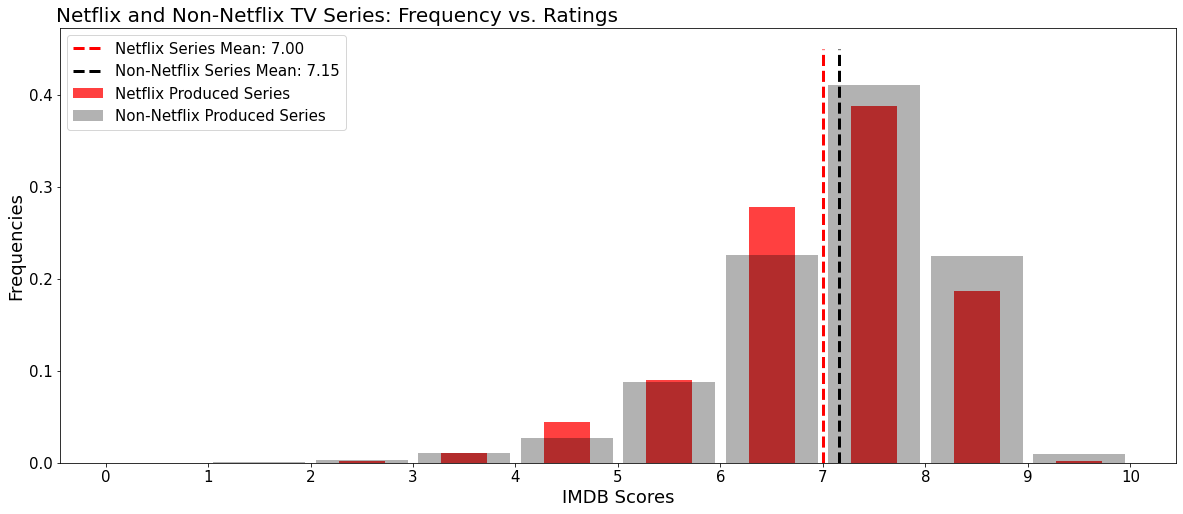

In [7]:
# HISTOGRAM OF NETFLIX VS. NON-NETFLIX TV SERIES BY IMDB SCORES

plt.figure(figsize=(20,8))

plt.hist(netflix_series_only["IMDb Score"], bins = np.arange(0,11), alpha=.75, density= True, rwidth=.45, color = "red")
plt.hist(non_netflix_series_count["IMDb Score"], bins = np.arange(0,11), alpha= .30, density=True, rwidth=.9, color = "black")

plt.vlines(netflix_series_only["IMDb Score"].mean(),0,.45,linestyles= "dashed", linewidth=3, color = "red")
plt.vlines(non_netflix_series_count["IMDb Score"].mean(),0,.45,linestyles= "dashed", linewidth=3, color="black")

plt.legend([ f"Netflix Series Mean: {netflix_series_only['IMDb Score'].mean():.2f}", f"Non-Netflix Series Mean: {non_netflix_series_count['IMDb Score'].mean():.2f}","Netflix Produced Series", "Non-Netflix Produced Series"], loc = "upper left", fontsize = 15)
plt.title("Netflix and Non-Netflix TV Series: Frequency vs. Ratings", size=20, horizontalalignment = "right")
plt.xlabel("IMDB Scores", size = 18)
plt.xticks(np.arange(0, 11,1.0), size = 15)
plt.ylabel("Frequencies", size = 18)
plt.yticks(size = 15)

plt.savefig("Netflix_Series.png")
plt.show()

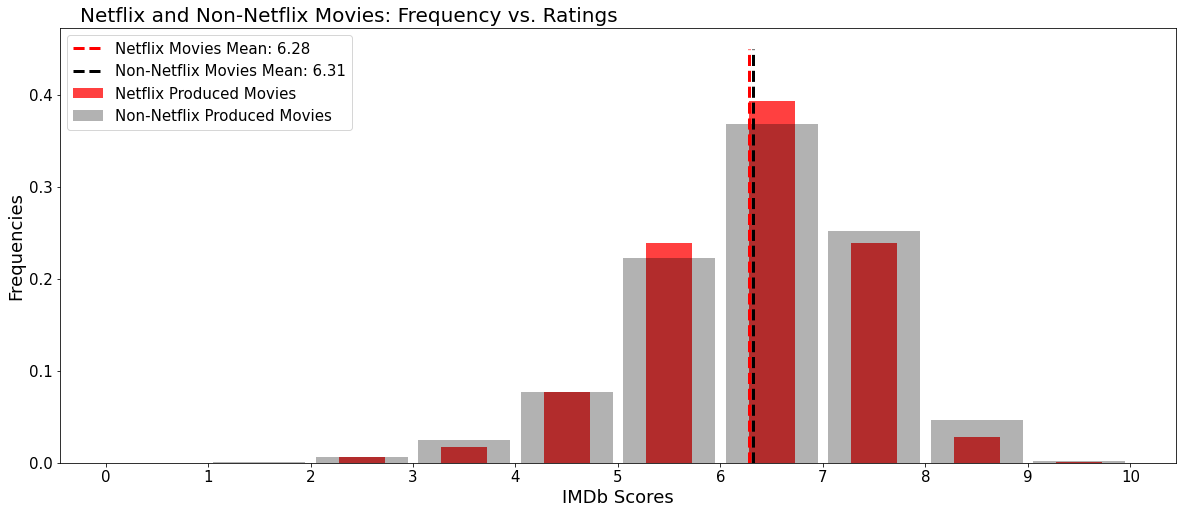

In [8]:
# HISTOGRAM OF NETFLIX VS. NON-NETFLIX MOVIES BY IMDB SCORES

plt.figure(figsize=(20,8))

plt.hist(only_nf_movies["IMDb Score"], bins = np.arange(0,11), alpha=.75, density= True, rwidth=0.45, color= "red", align = "mid")
plt.hist(non_netflix_movies_df["IMDb Score"], bins = np.arange(0,11), alpha= .30, density=True, rwidth=0.9, color = "black", align = "mid")

plt.vlines(only_nf_movies["IMDb Score"].mean(),0,.45,linestyles= "dashed", linewidth=3, color= "red")
plt.vlines(non_netflix_movies_df["IMDb Score"].mean(),0,.45,linestyles= "dashed", linewidth=3, color = "black")

plt.legend([ f"Netflix Movies Mean: {only_nf_movies['IMDb Score'].mean():.2f}", f"Non-Netflix Movies Mean: {non_netflix_movies_df['IMDb Score'].mean():.2f}","Netflix Produced Movies", "Non-Netflix Produced Movies"], loc = "upper left", fontsize = 15)
plt.title("Netflix and Non-Netflix Movies: Frequency vs. Ratings", size = 20, horizontalalignment = "right") 
plt.xlabel("IMDb Scores", size = 18)
plt.xticks(np.arange(0, 11,1.0), size = 15)
plt.ylabel("Frequencies", size = 18)
plt.yticks(size = 15)

plt.savefig("Netflix_Movies.png")
plt.show()

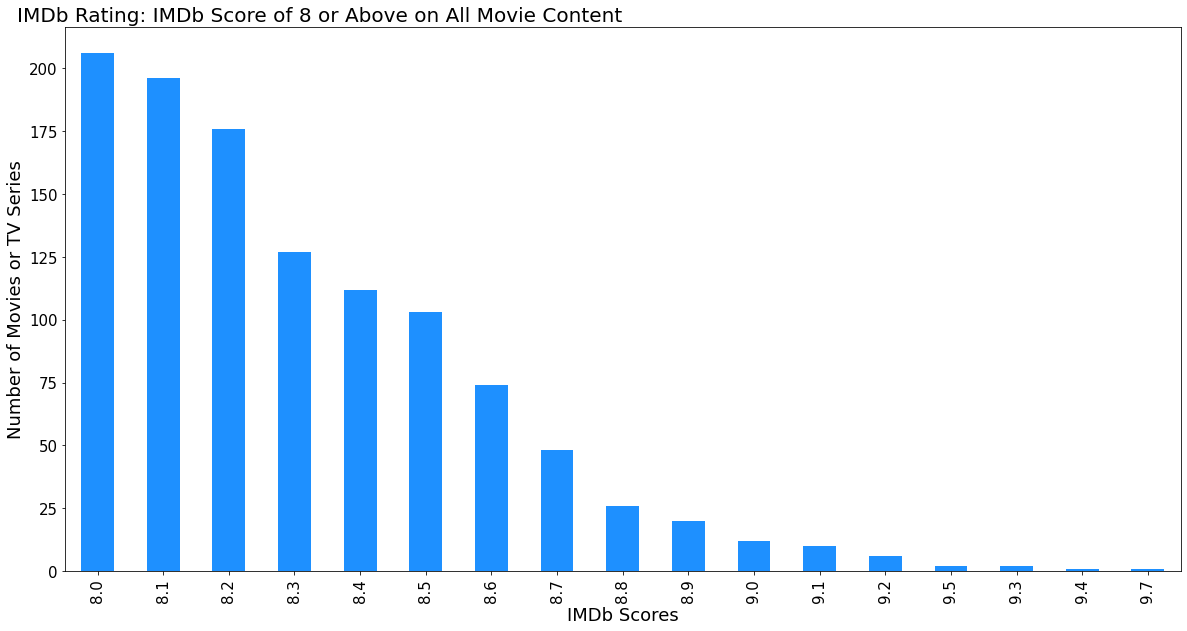

In [9]:
# GRAPH SHOWING FREQUENCY OF ALL CONTENT WITH AT LEAST AN 8.0 IMDB SCORE

plt.figure(figsize=(20,10))

IMDb_df["IMDb Score"].value_counts().plot(kind="bar",color= "dodgerblue" )

plt.title("IMDb Rating: IMDb Score of 8 or Above on All Movie Content", size = 20, horizontalalignment = "right")
plt.xlabel("IMDb Scores", size = 18)
plt.ylabel("Number of Movies or TV Series", size = 18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.savefig("IMDb.png")
plt.show()

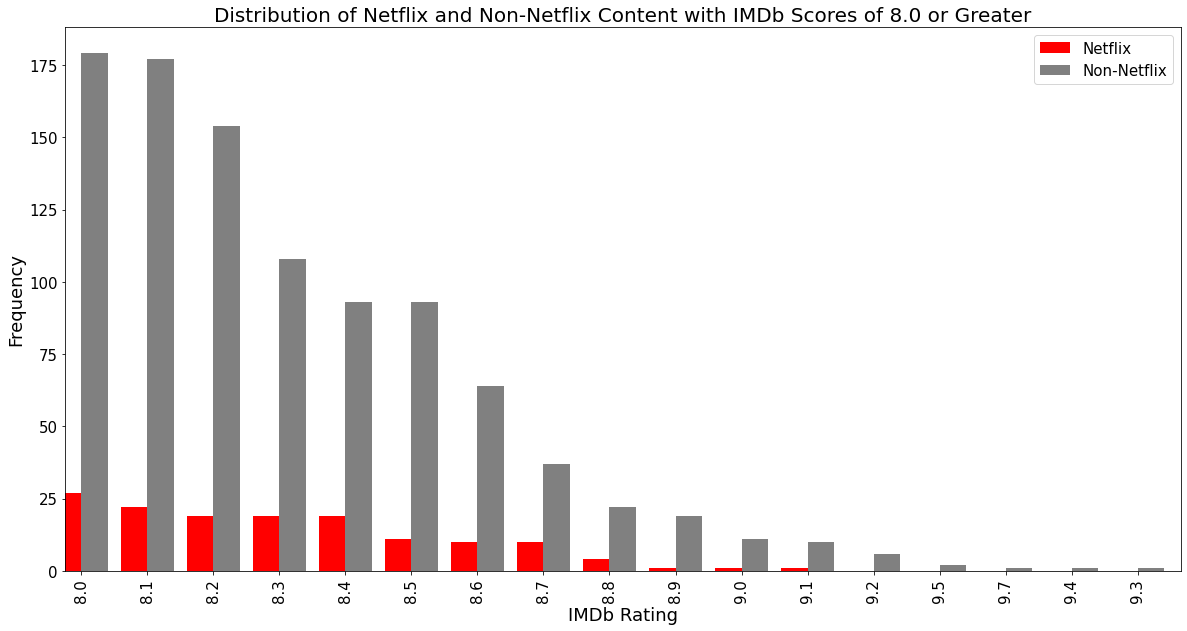

In [10]:
# GRAPH SHOWING FREQUENCY OF NETFLIX VS NON-NETFLIX CONTENT WITH AT LEAST AN 8.0 IMDB SCORE

plt.figure(figsize=(20,10))
bar_width = 0.4
IMDb_netflix["IMDb Score"].value_counts().plot(kind="bar", position=1, color= "red", width=bar_width )
IMDb_non_netflix["IMDb Score"].value_counts().plot(kind="bar", position=0, color= "grey", width=bar_width)

plt.title("Distribution of Netflix and Non-Netflix Content with IMDb Scores of 8.0 or Greater", size = 20, horizontalalignment = "center")
plt.xlabel("IMDb Rating", size = 18)
plt.ylabel("Frequency", size = 18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.legend(["Netflix", "Non-Netflix"],loc = "upper right", fontsize = 15)
plt.savefig("IMDb_nf_non_nf.png")
plt.show()

In [11]:
# MADELYN

# SEPARATE CONTENT INTO A DATAFRAMES FOR NETFLIX-PRODUCED ITEMS AND NON-NETFLIX PRODUCED ITEMS
netflix_df = df[df['Release Date'] == df['Netflix Release Date']]
other_df = df[df['Release Date'] != df['Netflix Release Date']]

# IDENTIFY ACTORS IN NETFLIX-PRODUCED CONTENT
netflix_actors = netflix_df['Actors'].str.split(',\s+', expand=True).stack().value_counts()
n_actors_freq = netflix_actors.value_counts()
netflix_actorss = pd.Series(netflix_actors)
netflix_acts = pd.DataFrame(netflix_actorss)

# TEST DISTRIBUTION FOR NORMALCY
netflix_actors_normtst = st.normaltest(netflix_actors.sample(25))

# IDENTIFY ACTORS WHO APPEARED IN MULTIPLE NETFLIX CONTENT ITEMS
reused_n_actors = netflix_acts[netflix_acts > 1]

# IDENTIFY ACTORS IN NON-NETFLIX PRODUCED CONTENT
nonnetflix_actors = other_df['Actors'].str.split(',\s+', expand=True).stack().value_counts()
nn_actors_freq = other_df.value_counts()
nonnetflix_actorss = pd.Series(nonnetflix_actors)
nonnetflix_acts = pd.DataFrame(nonnetflix_actorss)

other_actors = other_df['Actors'].str.split(',\s+', expand=True).stack().value_counts()
o_actors_freq = other_actors.value_counts()
other_actorss = pd.Series(other_actors)
other_acts = pd.DataFrame(other_actorss)
reused_o_actors = other_acts[other_acts > 1]

Text(0.5, 0, 'Number of Movies Acted In')

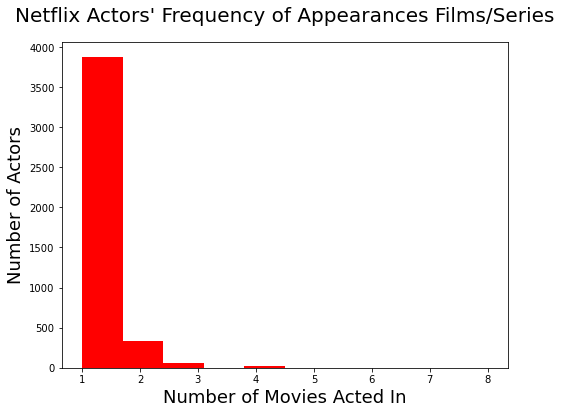

In [12]:
# DISTRIBUTION OF ALL ACTORS 
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(netflix_actors, color='r')
plt.title("Netflix Actors' Frequency of Appearances Films/Series",size = 20, horizontalalignment = "center", pad = 20)
plt.ylabel('Number of Actors',size=18)
plt.xlabel('Number of Movies Acted In',size=18)

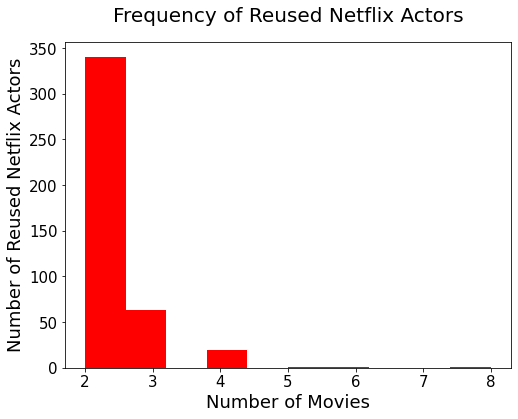

In [13]:
# DISTRIBUTION OF ACTORS WHO STARRED IN NETFLIX FILMS AT LEAST TWICE
plt.hist(reused_n_actors, color="red")
plt.title('Frequency of Reused Netflix Actors',size = 20, horizontalalignment = "center", pad = 20)
plt.ylabel('Number of Reused Netflix Actors', size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [14]:
# AVERAGE NUMBER OF MOVIES NETFLIX ACTORS APPEARED IN
netflix_actors.mean()

1.1260758315887416

In [15]:
# AVERAGE NUMBER OF MOVIES NETFLIX ACTORS APPEARED IN
other_actors.mean()

1.7963206307490145

In [16]:
# STANDARD DEVIATION OF THE NETFLIX ACTORS DATASET
netflix_actors.std()

0.4297203575420478

In [17]:
# STANDARD DEVIATION OF NON-NETFLIX ACTORS DATASET
other_actors.std()

2.1785613475960592

<b> 90% of netflix actors only appeared on one film/series </b><br>
4299 individual actors for Netflix. That's 1.13 movies per actor <br><br>
idea: say something about how many times an actor/writer/director/production house only worked on one film/series. that is a number that can be turned into a comparable percentage

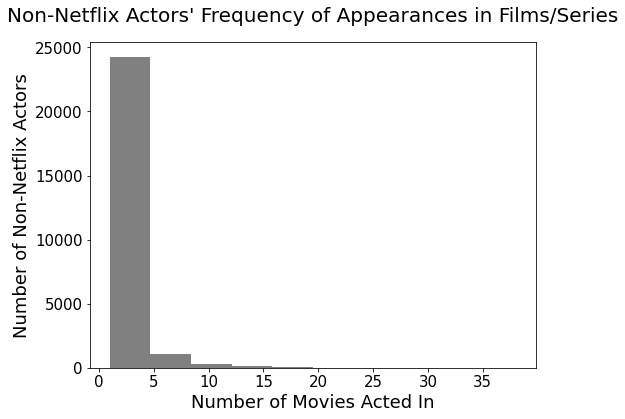

In [18]:
# DISTRIBUTION OF ACTORS WHO STARRED IN NON-NETFLIX CONTENT
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(other_actors, color="grey")
plt.title("Non-Netflix Actors' Frequency of Appearances in Films/Series",size=20, pad = 20)
plt.ylabel('Number of Non-Netflix Actors',size=18)
plt.xlabel('Number of Movies Acted In',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

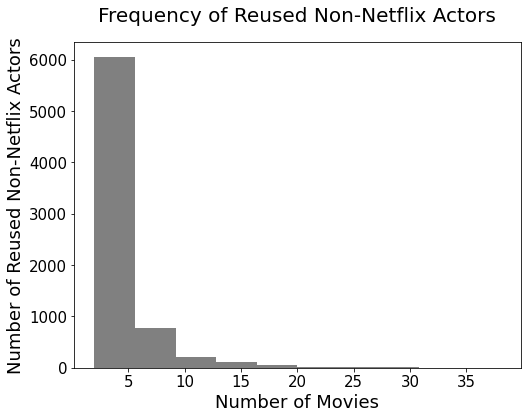

In [19]:
# DISTRIBUTION OF ACTORS WHO STARRED IN NON-NETFLIX CONTENT AT LEAST TWICE
plt.hist(reused_o_actors, color="grey")
plt.title("Frequency of Reused Non-Netflix Actors", size=20, pad = 20)
plt.ylabel('Number of Reused Non-Netflix Actors',size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

<b>72% of other produced films/series actors only appeared on one film/series </b><br><br>
25874 individual actors for non-Netflix. That's 1.8 movies per actor (what are you saying?)

<b> Writers count <b>

In [20]:
# IDENTIFY NETFLIX WRITERS AND NUMBER OF ITEMS THEY'RE ASSOCIATED WITH
netflix_writers = netflix_df['Writer'].str.split(',\s+', expand=True).stack().value_counts()
n_writers_freq = netflix_writers.value_counts()

netflix_writerss = pd.Series(netflix_writers)
net_writers = pd.DataFrame(netflix_writerss)
reused_n_writers = net_writers[net_writers > 1]

# IDENTIFY WRITERS IN NON-NETFLIX CONTENT AND THE ITEMS THEY'RE ASSOCIATED WITH
other_writers = other_df['Writer'].str.split(',\s+', expand=True).stack().value_counts()
o_writers_freq = other_writers.value_counts()

other_writerss = pd.Series(other_writers)
oth_writers = pd.DataFrame(other_writerss)
reused_o_writers = oth_writers[oth_writers > 1]

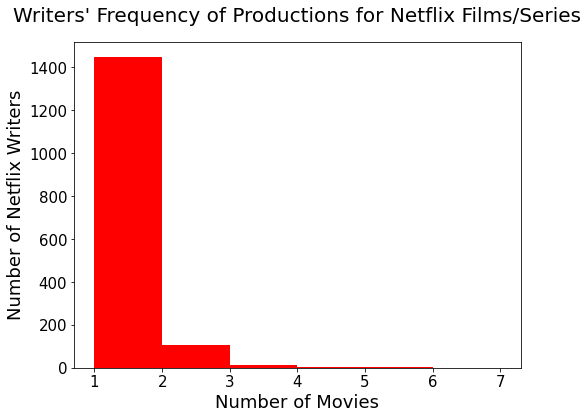

In [21]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(netflix_writers, bins=[1,2,3,4,5,6,7], color='r')
plt.title("Writers' Frequency of Productions for Netflix Films/Series",size=20, pad = 20)
plt.ylabel('Number of Netflix Writers',size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

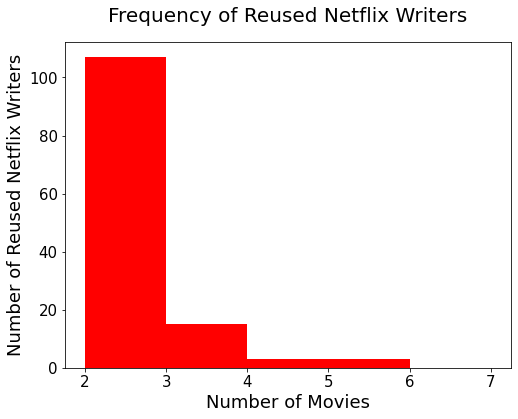

In [22]:
plt.hist(reused_n_writers, color='r',bins=[2,3,4,5,6,7])
plt.title("Frequency of Reused Netflix Writers", size=20,pad = 20)
plt.ylabel('Number of Reused Netflix Writers',size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [23]:
# AVERAGE CONTENT ITEMS NETFLIX WRITERS WERE NAMED IN
netflix_writers.mean()

1.100253807106599

In [24]:
# STANDARD DEVIATION OF WRITERS ASSOCIATED WITH NETFLIX ITEMS
netflix_writers.std()

0.37893744382772965

<b> 92% of Netflix writers only wrote for one film/series </b>

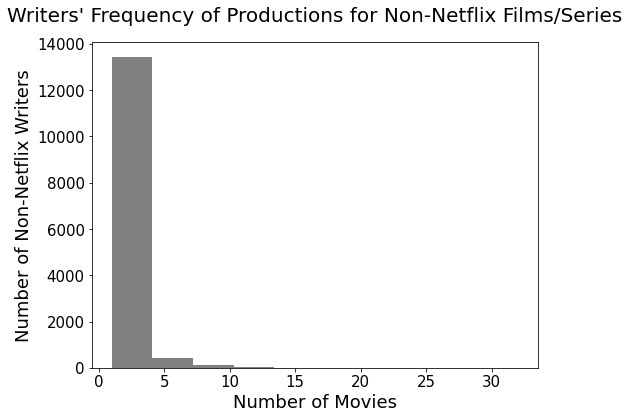

In [25]:
# NON-NETFLIX WRITERS
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(other_writers, color="grey")
plt.title("Writers' Frequency of Productions for Non-Netflix Films/Series",size=20, pad = 20)
plt.ylabel('Number of Non-Netflix Writers',size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

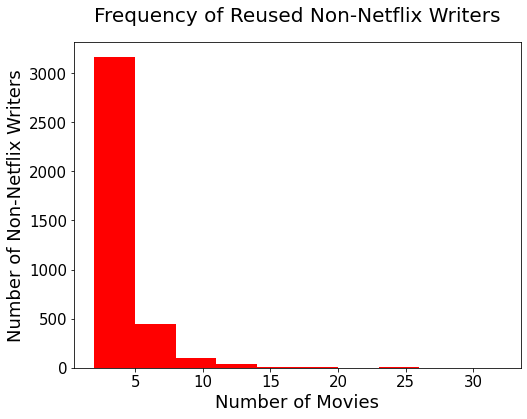

In [26]:
plt.hist(reused_o_writers, color='r')
plt.title("Frequency of Reused Non-Netflix Writers",size=20, pad = 20)
plt.ylabel('Number of Non-Netflix Writers',size=18)
plt.xlabel('Number of Movies',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [27]:
other_writers.mean()

1.5967351012261193

In [28]:
other_writers.std()

1.5035835729421738

<b> 73% of other produced films/series writers only wrote for one film/series </b>

<b> Directors count </b>

In [29]:
# DIRECTORS OF NETFLIX MOVIES
netflix_directors = netflix_df['Director'].str.split(',\s+', expand=True).stack().value_counts()
n_directors_freq = netflix_directors.value_counts()

netflix_directorss = pd.Series(netflix_directors)
net_directors = pd.DataFrame(netflix_directorss)
reused_n_directors = net_directors[net_directors > 1]

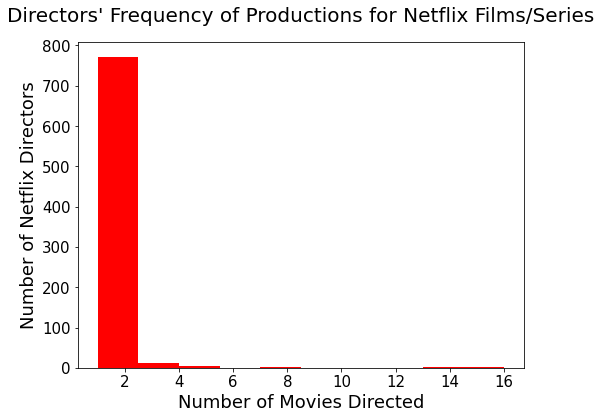

In [30]:
# DISTRIBUTION OF NETFLIX DIRECTORS BY COUNT OF MOVIES DIRECTED
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(netflix_directors, color='r')
plt.title("Directors' Frequency of Productions for Netflix Films/Series",size=20, pad = 20)
plt.ylabel('Number of Netflix Directors',size=18)
plt.xlabel('Number of Movies Directed',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

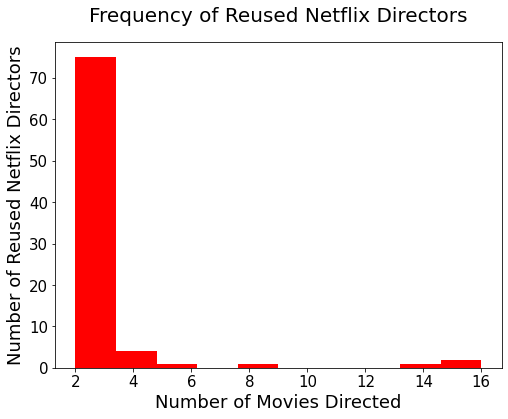

In [31]:
# DISTRIBUTION OF NETFLIX DIRECTORS WHO DIRECTED AT LEAST 2 MOVIES
plt.hist(reused_n_directors, color='r')
plt.title("Frequency of Reused Netflix Directors",size=20, pad = 20)
plt.ylabel('Number of Reused Netflix Directors',size=18)
plt.xlabel('Number of Movies Directed',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [32]:
# AVERAGE NUMBER OF NETFLIX-MOVIES DIRECTED BY NETFLIX DIRECTORS
netflix_directors.mean()

1.1931818181818181

In [33]:
# STANDARD DEVIATION OF NETFLIX DIRECTORS
netflix_directors.std()

1.0065796071146602

<b> 89% of netflix produced films/series directors only directed for one film/series </b>

In [34]:
# DIRECTORS OF NON-NETFLIX CONTENT ITEMS
other_directors = other_df['Director'].str.split(',\s+', expand=True).stack().value_counts()
o_directors_freq = other_directors.value_counts()

other_directorss = pd.Series(other_directors)
oth_directors = pd.DataFrame(other_directorss)
reused_o_directors = oth_directors[oth_directors > 1]

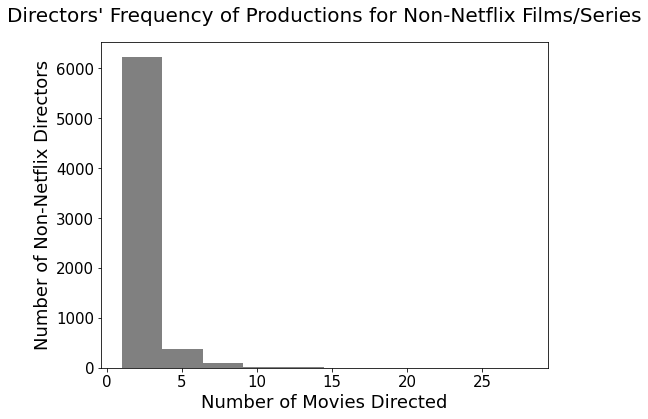

In [35]:
# DISTRIBUTION OF DIRECTORS WHO DIRECTED NON-NETFLIX CONTENT ITEMS
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(other_directors,color="grey")
plt.title("Directors' Frequency of Productions for Non-Netflix Films/Series",size=20, pad = 20)
plt.ylabel('Number of Non-Netflix Directors',size=18)
plt.xlabel('Number of Movies Directed',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

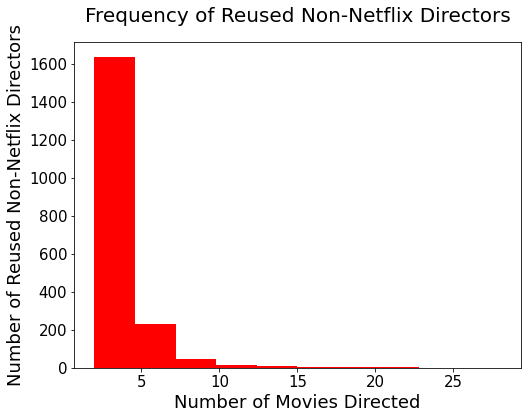

In [36]:
# DISTRIBUTION OF DIRECTORS WHO DIRECTED AT LEAST 2 NON-NETFLIX CONTENT ITEMS
plt.hist(reused_o_directors, color='r')
plt.title("Frequency of Reused Non-Netflix Directors",size=20, pad = 20)
plt.ylabel('Number of Reused Non-Netflix Directors',size=18)
plt.xlabel('Number of Movies Directed',size=18)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

In [37]:
# AVERAGE NUMBER OF MOVIES PER DIRECTOR OF DIRECTORS FOR NON-NETFLIX CONTENT ITEMS
other_directors.mean()

1.640029761904762

In [38]:
# STANDARD DEVIATION OF NON-NETFLIX CONTENT ITEMS PER DIRECTOR
other_directors.std()

1.5277476226908788

In [39]:
# NORMALCY TEST OF NON-NETFLIX DIRECTORS
st.normaltest(other_directors)

NormaltestResult(statistic=6880.066596512085, pvalue=0.0)

<b> 71% of other produced films/series directors only directed for one film/series </b>

<b> Production Houses count </b>

In [40]:
# PRODUCTION HOUSES
netflix_houses = netflix_df['Production House'].str.split(',\s+', expand=True).stack().value_counts()
n_houses_freq = netflix_houses.value_counts()

print(st.normaltest(netflix_houses))

# NON-NETFLIX PRODUCTION HOUSES
other_houses = other_df['Production House'].str.split(',\s+', expand=True).stack().value_counts()
o_houses_freq = other_houses.value_counts()

NormaltestResult(statistic=513.663034569928, pvalue=2.880641839827196e-112)


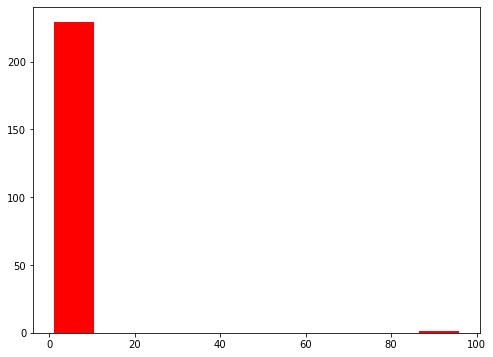

In [41]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(netflix_houses, color = "red")
plt.show()

In [42]:
netflix_houses.mean()

1.6

In [43]:
netflix_houses.std()

6.276454927973479

<b> 87% of netflix produced films/series production houses were only used for one film/series </b>

(array([3.809e+03, 5.700e+01, 9.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1.,  15.,  29.,  43.,  57.,  71.,  85.,  99., 113., 127., 141.]),
 <BarContainer object of 10 artists>)

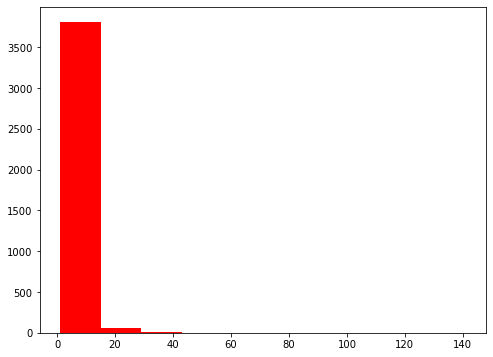

In [44]:
plt.rcParams["figure.figsize"] = (8,6)
plt.hist(other_houses, color = "red")

In [45]:
other_houses.mean()

2.5395109395109396

In [46]:
other_houses.std()

5.470527368422982

### IMDb API
<br>IMDb's API call was used to determine the counts of awards and nominations for movies. These values were re-merged with the kaggle dataset to compare IMBd Scores to the volume of awards. <br>
<i>Note: "Awards" in this context refers to <b>both</b> award nominations and award wins. When referring to specifically wins or nominations, "wins" or "nominations" is stated.</i>

In [47]:
# REDUCING THE KAGGLE DATASET TO ITEMS WITH IMBD IDS
kaggle_IMDb = kaggle_all[kaggle_all["IMDb ID"].notna()]
kaggle_netflix_ct=kaggle_IMDb["NetflixProduced"].value_counts()
len(kaggle_all)
kaggle_netflix_items = len(kaggle_all[(kaggle_all["NetflixProduced"]==True)])
kaggle_nonnetflix_items = len(kaggle_all[(kaggle_all["NetflixProduced"]==False)])

# REDUCING THE DATASET AGAIN TO THOSE WITH AN AWARD INDICATED
kaggle_IMDb = kaggle_IMDb[kaggle_IMDb["Awards Nominated For"].notna()]

In [48]:
# MOVIES ONLY
kaggle_netflix_mo = len(kaggle_all[(kaggle_all["NetflixProduced"]==True)& (kaggle_all["Series or Movie"]=="Movie")])
kaggle_nonnetflix_mo = len(kaggle_all[(kaggle_all["NetflixProduced"]==False)& (kaggle_all["Series or Movie"]=="Movie")])

# TV SERIES ONLY
kaggle_netflix_tv = len(kaggle_all[(kaggle_all["NetflixProduced"]==True)& (kaggle_all["Series or Movie"]=="Series")])
kaggle_nonnetflix_tv = len(kaggle_all[(kaggle_all["NetflixProduced"]==False)& (kaggle_all["Series or Movie"]=="Series")])

#### API Calls
The IMDb API has a call limit of 5,000 records per day. <br>
In the course of preparing this data, multiple calls were made over the same number of rows, hence the duplicate ranges of indices shown in the API Call List section. <br><br>
<b> Do not uncomment and run the API Call List cell or the API Calls cells. They will error due to the API limit.</b>

In [49]:
# API Call Lists -- Do not UNCOMMENT this cell.

# Several lists of IMDb IDs were created to call the API in segments

# imdb_id_1 = (kaggle_IMDb.iloc[0:3714, 29]).tolist()
# imdb_id_2 = (kaggle_IMDb.iloc[518:3714,29]).tolist()
# imdb_id_3 = (kaggle_IMDb.iloc[748:5001,29]).tolist()
# imdb_id_4 = (kaggle_IMDb.iloc[855:1501,29]).tolist()
# imdb_id_5 = (kaggle_IMDb.iloc[1501:3000,29]).tolist()
# imdb_id_6 = (kaggle_IMDb.iloc[3000:3715,29]).tolist()
# imdb_id_7 = (kaggle_IMDb.iloc[3715:6001,29]).tolist()
# imdb_id_8 = (kaggle_IMDb.iloc[6001:7511,29]).tolist()

In [50]:
# API CALLS - 1 - DO NOT UNCOMMENT THIS CELL
# In hindsight, I should have come up with a loop solution for this...

# for each in imdb_id_1:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue
#         display(response.head())

In [51]:
# API CALLS - 2 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_2:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue

In [52]:
# API CALLS - 3 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_3:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue

In [53]:
# API CALLS - 4 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_4:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue

In [54]:
# API CALLS - 5 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_5:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue


In [55]:
# API CALLS - 6 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_6:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue


In [56]:
# API CALLS - 7 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_7:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue

In [57]:
# API CALLS - 8 - DO NOT UNCOMMENT THIS CELL

# for each in imdb_id_8:
#         try:
#             imdb_url = f"https://imdb-api.com/en/API/Awards/{imdb_apikey}/"
#             response = requests.get(imdb_url + each).json()
#             response = pd.DataFrame(response, index = [0])
#             response = response[["imDbId","title","fullTitle", "type","year", "description", "items"]]
#             response["items"].apply(pd.Series)
#             response = pd.concat([response, response["items"].apply(pd.Series)], axis =1)
#             response = response.explode("outcomeItems")
#             response["outcomeItems"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeItems"].apply(pd.Series)], axis=1)
#             response = response.explode("outcomeDetails")
#             response["outcomeDetails"].apply(pd.Series)
#             response = pd.concat([response, response["outcomeDetails"].apply(pd.Series)], axis=1)
#             response = response[["imDbId","title", "fullTitle", "type", "year", "description", "eventTitle", "eventYear", "outcomeTitle", "outcomeCategory", "plainText", "html"]]
#             for each in response:
#                 response.to_csv(r"../Resources/imdb_data.csv", mode = "a", index = False, header = False)
#         except Exception:

#             continue

In [58]:
# READ IN CSV FILE WITH IMDB AWARD DATA
imdb_data = "../Resources/imdb_data.csv"
awards_data = pd.read_csv(imdb_data)

# PARSE HTML COLUMN OF IMDB AWARD DATA TO GET THE AWARD NAME (E.G., BEST PICTURE) ONLY AND NOT ASSOCIATED ACTORS/DIRECTORS
awards_data_html = awards_data["html"]
awards_splt1 = awards_data_html.str.split("<p>",n=-1,expand=True)
awards_splt2 = awards_splt1[1].str.split("<b", n=-1,expand=True)
awards_splt2 = awards_splt2[0]

# kaggle_imdbid = kaggle_imdbid[4]

imdb_awards_a = pd.Series(awards_splt2, name="Award Name")
imdb_awards1 = awards_data.merge(imdb_awards_a,left_index=True, right_index=True)
imdb_awards1 = imdb_awards1[["imDbId", "title", "fullTitle", "type","year","description","eventTitle","eventYear","outcomeTitle","outcomeCategory", "Award Name"]]

# THE API CALLS CREATED DUPLICATE RECORDS
imdb_awards1.drop_duplicates(keep="first", inplace = True)
imdb_awards1.rename(columns={"imDbId": "IMDb ID"}, inplace = True)
# imdb_awards.head()

In [59]:
# MERGE KAGGLE_IMDB ONTO IMDB_AWARDS TO DETERMINE NETFLIX-PRODUCED OR NOT
imdb_awards = pd.merge(imdb_awards1, kaggle_IMDb[["IMDb Score", "Release Date", "Netflix Release Date","NetflixProduced", "IMDb ID"]], on="IMDb ID", how="left")
imdb_awards = imdb_awards.dropna()
# imdb_awards.info()

In [60]:
# NOMINATIONS AND WINS PER MOVIE / TV SERIES
imdb_awards_grp = imdb_awards.groupby(["IMDb ID", "title", "type","NetflixProduced", "outcomeTitle"])["outcomeCategory"].count()
imdb_awards_grp_df = pd.DataFrame(imdb_awards_grp).reset_index()
imdb_awards_pvt = imdb_awards_grp_df.pivot(index =["IMDb ID", "title", "type","NetflixProduced"], columns="outcomeTitle", values="outcomeCategory")
imdb_awards_pvt = imdb_awards_pvt.fillna(0)
imdb_awards_pvt.rename(columns = {"outcomeTitle": "Index"})
imdb_awards_pvt = imdb_awards_pvt.reset_index()
imdb_awards_pvt["TotalAwards"] = imdb_awards_pvt["Nominee"]+imdb_awards_pvt["Winner"]

# NETFLIX MOVIES / TV SERIES NOMINATIONS AND WINS
imdb_awards_netflix = len(imdb_awards_pvt[imdb_awards_pvt["NetflixProduced"]==True])

# WINS AND NOMINATIONS FOR NETFLIX MOVIES / TV SERIES (counts nominations/wins. Content items are not distinct)
imdb_awardsct_netflix = len(imdb_awards[imdb_awards["NetflixProduced"]==True])

# NON-NETFLIX MOVIES / TV SERIES NOMINATIONS AND WINS
imdb_awards_nonnetflix = len(imdb_awards_pvt[imdb_awards_pvt["NetflixProduced"]==False])

# WINS AND NOMINATIONS FOR NETFLIX MOVIES / TV SERIES (counts nominations/wins. Content items are not distinct)
imdb_awardsct_nonnetflix = len(imdb_awards[imdb_awards["NetflixProduced"]==False])


# imdb_awards_pvt


In [61]:
# TOTAL NUMBER OF UNIQUE AWARD NAMES
imdb_awards["eventTitle"].nunique()

348

In [62]:
# TOTAL NUMBER OF MOVIES AND TV SERIES WITH AWARDS
items_awards = imdb_awards["IMDb ID"].nunique()
items_awards

1281

In [63]:
# TOTAL NUMBER AWARDS FOR MOVIES AND TV SERIES
len(imdb_awards.index)

2476

In [64]:
# imdb_awards_grp_df.head()

In [65]:
# NUMBER OF ALL NETFLIX ITEMS WITH AWARDS
netflix_awards_all = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==True)])

# # NUMBER OF NETFLIX MOVIES WITH AWARDS
netflix_awards_mo = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==True) & (imdb_awards_grp_df["type"]=="Movie")])

# # NUMBER OF NETFLIX TV SERIES WITH AWARDS
netflix_awards_tv = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==True) & (imdb_awards_grp_df["type"]=="TVSeries")])

# NETFLIX PORTION OF THE AWARDS DATASET
netflix_items_portion = imdb_awards_netflix / items_awards
netflix_awards_portion = imdb_awardsct_netflix / len(imdb_awards.index)

print(f"{netflix_awards_all} Netflix-produced items in the dataset received awards")
print(f"{netflix_awards_mo} Netflix-produced movies received awards")
print(f"{netflix_awards_tv} Netflix-produced TV series received awards")
print("Netflix content represents "+ f"{netflix_items_portion:.2%}" + " of total awarded items in the dataset, \n and "+  f"{netflix_awards_portion:.2%}" + " of all awards are for Netflix-produced content.")

134 Netflix-produced items in the dataset received awards
76 Netflix-produced movies received awards
58 Netflix-produced TV series received awards
Netflix content represents 8.74% of total awarded items in the dataset, 
 and 7.51% of all awards are for Netflix-produced content.


In [66]:
# NUMBER OF AWARDS (WINS AND NOMIATIONS) FOR ALL NON-NETFLIX ITEMS
nonnetflix_awards_all = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==False)])

# NUMBER OF NETFLIX MOVIES WITH AWARDS
nonnetflix_awards_mo = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==False) & (imdb_awards_grp_df["type"]=="Movie")])

# # NUMBER OF NETFLIX TV SERIES WITH AWARDS
nonnetflix_awards_tv = len(imdb_awards_grp_df[(imdb_awards_grp_df["NetflixProduced"]==False) & (imdb_awards_grp_df["type"]=="TVSeries")])

# NON-NETFLIX PORTION OF THE AWARDS DATASET
nonnetflix_items_portion = imdb_awards_nonnetflix / items_awards
nonnetflix_awards_portion = imdb_awardsct_nonnetflix / len(imdb_awards.index)

print(f"{nonnetflix_awards_all} Non-Netflix-produced items in the dataset received awards")
print(f"{nonnetflix_awards_mo} Non-Netflix-produced movies received awards")
print(f"{nonnetflix_awards_tv} Non-Netflix-produced TV series received awards")
print("Non-Netflix content represents "+ f"{nonnetflix_items_portion:.2%}" + " of total awarded items in the dataset, \n and "+  f"{nonnetflix_awards_portion:.2%}" + " of all awards are for Non-Netflix-produced content.")

1339 Non-Netflix-produced items in the dataset received awards
1084 Non-Netflix-produced movies received awards
255 Non-Netflix-produced TV series received awards
Non-Netflix content represents 91.26% of total awarded items in the dataset, 
 and 92.49% of all awards are for Non-Netflix-produced content.


In [67]:
# PORTION OF NETFLIX ITEMS THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NETFLIX ITEMS IN THE KAGGLE SET
netflix_awards_all_pct = (netflix_awards_all / kaggle_netflix_items)*100
print("{:.2f}%".format(netflix_awards_all_pct))

9.13%


In [68]:
# PORTION OF NON-NETFLIX ITEMS THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NETFLIX ITEMS IN THE KAGGLE SET
nonnetflix_awards_all_pct = (nonnetflix_awards_all/ kaggle_nonnetflix_items)*100
print("{:.2f}%".format(nonnetflix_awards_all_pct))

9.56%


In [69]:
# PERCENTAGE DIFFERENCE BETWEEN NETFLIX AND NON-NETFLIX AWARD PROPORTIONS
nonn_netf_all_comp_pct = netflix_awards_all_pct / nonnetflix_awards_all_pct
print("Even though there are significantly more non-Netflix items in the set, both Netflix and non-Netflix items received awards (nominations and wins) at similar rates. " + f"{netflix_awards_all_pct:.2%}" + " percent of Netflix items in the total kaggle dataset were nominated or won an award, compared to "+ f"{nonnetflix_awards_all_pct:.2%}" + " percent for Non-Netflix content.")

Even though there are significantly more non-Netflix items in the set, both Netflix and non-Netflix items received awards (nominations and wins) at similar rates. 913.43% percent of Netflix items in the total kaggle dataset were nominated or won an award, compared to 955.54% percent for Non-Netflix content.


In [70]:
# PORTION OF NETFLIX MOVIES THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NETFLIX MOVIES IN THE KAGGLE SET
netflix_awards_mo_pct = (netflix_awards_mo/kaggle_netflix_mo)*100
print("{:.2f}%".format(netflix_awards_mo_pct))


9.18%


In [71]:
# PORTION OF NON-NETFLIX MOVIES THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NETFLIX MOVIES IN THE KAGGLE SET
nonnetflix_awards_mo_pct = (nonnetflix_awards_mo  / kaggle_nonnetflix_mo)*100
print("{:.2f}%".format(nonnetflix_awards_mo_pct))

9.97%


In [72]:
# PORTION OF NETFLIX TV SERIES THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NETFLIX TV SERIES IN THE KAGGLE SET
netflix_awards_tv_pct = (netflix_awards_tv/kaggle_netflix_tv)*100
print("{:.2f}%".format(netflix_awards_tv_pct))

9.08%


In [73]:
# PORTION OF NON-NETFLIX TV SERIES THAT RECEIVED AN AWARD (NOMINATIONS AND WINS) OF ALL NON-NETFLIX TV SERIES IN THE KAGGLE SET
nonnetflix_awards_tv_pct = (nonnetflix_awards_tv/kaggle_netflix_tv)*100
print("{:.2f}%".format(nonnetflix_awards_tv_pct ))

39.91%


In [74]:
# TOTAL AWARDS (NOMINATIONS AND WINS) BY AWARD NAME, CONTENT TYPE, AND IF IT WAS PRODUCED BY NETFLIX

award_orgs_awardct = imdb_awards.groupby(["type", "eventTitle","NetflixProduced", ])["IMDb ID"].count()
award_orgs_awardct = pd.DataFrame(award_orgs_awardct).sort_values(by = ["IMDb ID", "type","eventTitle",  "NetflixProduced"], ascending= False)
award_orgs_awardct = award_orgs_awardct.rename({"IMDb ID": "Award Count"}, axis = 1)
# award_orgs_awardct.head()


In [75]:
# TOTAL MOVIES/TV SERIES WITH AWARDS (NOMINATIONS AND WINS) BY AWARD NAME, CONTENT TYPE, AND IF IT WAS PRODUCED BY NETFLIX

award_orgs_itemct = imdb_awards.groupby(["type", "eventTitle","NetflixProduced", ])["IMDb ID"].nunique()
award_orgs_itemct = pd.DataFrame(award_orgs_itemct).sort_values(by = ["IMDb ID", "type","eventTitle",  "NetflixProduced"], ascending= False)
award_orgs_itemct = award_orgs_itemct.rename({"IMDb ID": "Unique Items"}, axis = 1)
# award_orgs_itemct.head()

In [76]:
# TOTAL MOVIES WITH AWARD NOMINATIONS AND WINS BY ORGANIZATION

award_orgs_movies = imdb_awards[(imdb_awards.type == "Movie")]
award_orgs_movies = award_orgs_movies[["eventTitle", "NetflixProduced", "IMDb ID"]]
award_orgs_movies_grp = pd.pivot_table(award_orgs_movies, index = ["eventTitle"], columns=["NetflixProduced"], aggfunc=lambda x: len(x.unique()))
# award_orgs_movies_grp.sort_values(by = [("IMDb ID", True)], ascending = False).head(20)


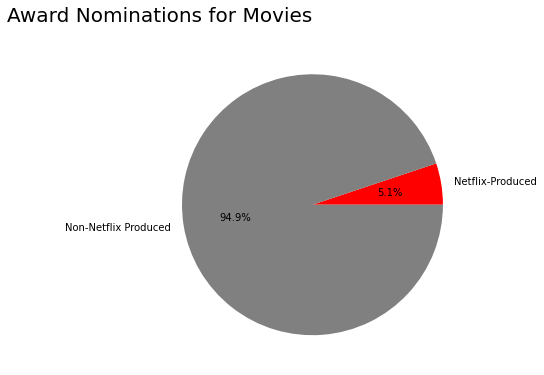

In [77]:
# AWARDS FOR MOVIES
# Nominations
awards_nom_mo = imdb_awards[(imdb_awards.type == "Movie") & (imdb_awards.outcomeTitle == "Nominee")]
awards_nom_mo = awards_nom_mo[["outcomeTitle", "NetflixProduced", "IMDb ID"]]

netflix_mo_noms = len(awards_nom_mo[(awards_nom_mo.NetflixProduced == True)])
nonnetflix_mo_noms = len(awards_nom_mo[(awards_nom_mo.NetflixProduced == False)])

mo_noms_piechart = [netflix_mo_noms , nonnetflix_mo_noms]
colors = ["red", "grey"]
labels = ["Netflix-Produced", "Non-Netflix Produced"]
plt.pie(mo_noms_piechart, labels = labels, autopct='%1.1f%%', colors = colors)
plt.title("Award Nominations for Movies", size = 20, pad =20,horizontalalignment="right" )
plt.show()


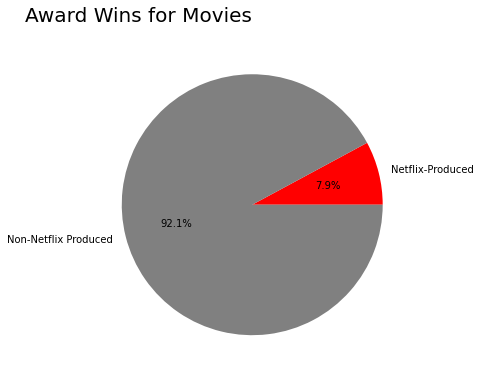

In [78]:
# AWARD WINS FOR MOVIES

awards_won_movies = imdb_awards[(imdb_awards.type == "Movie") & (imdb_awards.outcomeTitle == "Winner")]
awards_won_movies = awards_won_movies[["outcomeTitle", "NetflixProduced", "IMDb ID"]]

netflix_movies_wins = len(awards_won_movies[(awards_won_movies.NetflixProduced == True)])
nonnetflix_movies_wins = len(awards_won_movies[(awards_won_movies.NetflixProduced == False)])

movies_wins_piechart = [netflix_movies_wins, nonnetflix_movies_wins]
colors = ["red", "grey"]
labels = ["Netflix-Produced", "Non-Netflix Produced"]
plt.pie(movies_wins_piechart, labels = labels, autopct='%1.1f%%', colors=colors)
plt.title("Award Wins for Movies", size = 20, pad =20,horizontalalignment="right" )
plt.show()

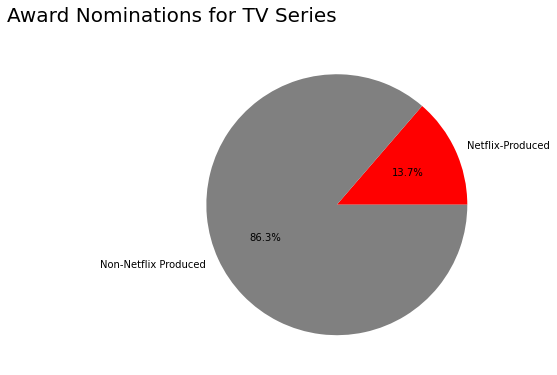

In [79]:
# AWARD NOMINATIONS FOR TV SERIES

awards_nom_tv = imdb_awards[(imdb_awards.type == "TVSeries") & (imdb_awards.outcomeTitle == "Nominee")]
awards_nom_tv = awards_nom_tv[["outcomeTitle", "NetflixProduced", "IMDb ID"]]

netflix_tv_noms = len(awards_nom_tv[(awards_nom_tv.NetflixProduced == True)])
nonnetflix_tv_noms = len(awards_nom_tv[(awards_nom_tv.NetflixProduced == False)])

tv_noms_piechart = [netflix_tv_noms, nonnetflix_tv_noms]
colors = ["red", "grey"]
labels = ["Netflix-Produced", "Non-Netflix Produced"]
plt.pie(tv_noms_piechart, labels = labels, autopct='%1.1f%%', colors = colors)
plt.title("Award Nominations for TV Series", size = 20, pad =20,horizontalalignment="right" )
plt.show()

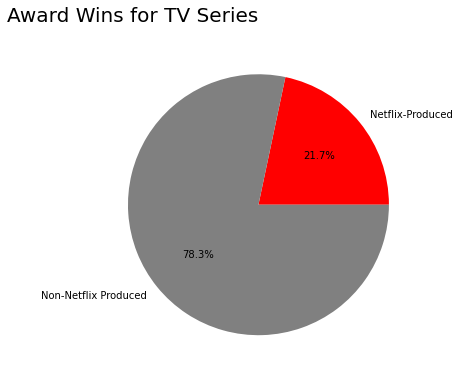

In [80]:
# AWARD WINS FOR TV SERIES

awards_won_tv = imdb_awards[(imdb_awards.type == "TVSeries") & (imdb_awards.outcomeTitle == "Winner")]
awards_won_tv = awards_won_tv[["outcomeTitle", "NetflixProduced", "IMDb ID"]]

netflix_tv_wins = len(awards_won_tv[(awards_won_tv.NetflixProduced == True)])
nonnetflix_tv_wins = len(awards_won_tv[(awards_won_tv.NetflixProduced == False)])

tv_wins_piechart = [netflix_tv_wins, nonnetflix_tv_wins]
colors = ["red", "grey"]
labels = ["Netflix-Produced", "Non-Netflix Produced"]
plt.pie(tv_wins_piechart, labels = labels, autopct='%1.1f%%', colors = colors)
plt.title("Award Wins for TV Series", size = 20, pad =20,horizontalalignment="right" )
plt.show()

In [81]:
# AMONG TV SERIES, DOES NETFLIX RECEIVE A DISPROPORITIONATE NUMBER OF AWARD NOMINATIONS AND/OR WINS?

netflix_tvwin_pct = netflix_tv_wins / kaggle_netflix_tv
netflix_tvnom_pct = netflix_tv_noms / kaggle_netflix_tv

nonnetflix_tvwin_pct = nonnetflix_tv_wins / kaggle_nonnetflix_tv 
nonnetflix_tvnom_pct = nonnetflix_tv_noms / kaggle_nonnetflix_tv 

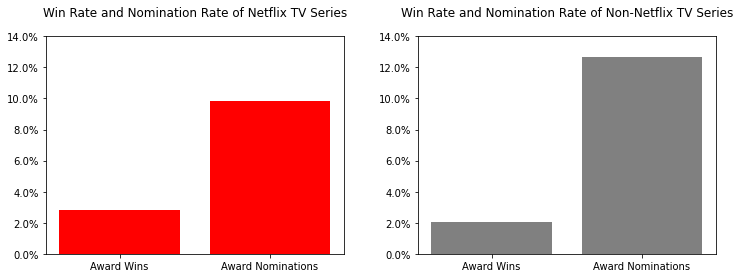

Award Win Rate of Netflix-Produced TV Series: 2.82%
Award Nomination Rate of Netflix-Produced TV Series: 9.86%
Award Win Rate of Non-Netflix Produced TV Series: 2.07%
Award Nomination Rate of Non-Netflix Produced TV Series: 12.66%


In [82]:
# BAR CHARTS COMPARING THE AWARD AND NOMINATION RATES OF NETFLIX AND NON-NETFLIX TV SERIES
fmt_pct = ":.2f%"
netflixtv_winrate_bar =[netflix_tvwin_pct,netflix_tvnom_pct]
nonnetflixtv_winrate_bar = [nonnetflix_tvwin_pct, nonnetflix_tvnom_pct]
labels = ["Award Wins","Award Nominations"]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
plt.subplots_adjust(wspace = 0.25)

ax1.bar(labels, netflixtv_winrate_bar, color = "red")
ax1.set_ylim(0, 0.14)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax1.set_title("Win Rate and Nomination Rate of Netflix TV Series", loc="center", pad = 20)

ax2.bar(labels, nonnetflixtv_winrate_bar, color = "grey")
ax2.set_ylim(0, 0.14)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.set_title("Win Rate and Nomination Rate of Non-Netflix TV Series", loc="center", pad = 20)


plt.draw()
plt.show()
print("Award Win Rate of Netflix-Produced TV Series: "+f"{netflix_tvwin_pct:.2%}")
print("Award Nomination Rate of Netflix-Produced TV Series: " + f"{netflix_tvnom_pct:.2%}")
print("Award Win Rate of Non-Netflix Produced TV Series: "+ f"{nonnetflix_tvwin_pct:.2%}")
print("Award Nomination Rate of Non-Netflix Produced TV Series: "+ f"{nonnetflix_tvnom_pct:.2%}")


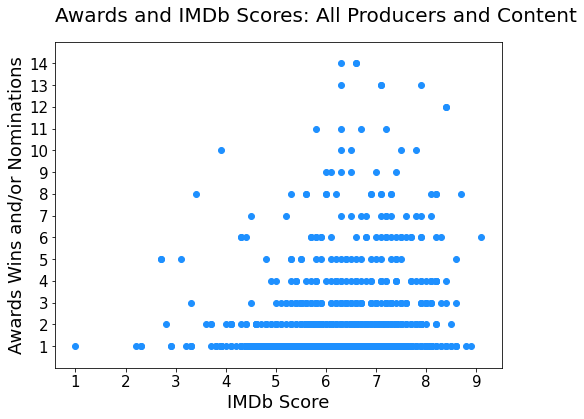

In [83]:
# SCATTER PLOT WHERE EACH MOVIE / TV SERIES IS ONE DOT AND X = IMDB SCORE AND Y = TOTAL AWARDS / WINS / NOMS

# MERGE THE IMBD AWARDS PIVOT TO GET AWARDS, WINS, NOMINATIONS, AND IMDB SCORE IN THE SAME FRAME
awards_scores_all = pd.merge(imdb_awards_pvt, kaggle_IMDb[["IMDb ID", "IMDb Score"]], on = "IMDb ID", how = "left")

# ALL AWARDS 
awards_won_moviestv_y = awards_scores_all["TotalAwards"]
awards_won_imdbscore_x =  awards_scores_all["IMDb Score"]
awards_scores_all_grp = awards_scores_all.groupby("NetflixProduced")

plt.scatter(awards_won_imdbscore_x, awards_won_moviestv_y, color = "dodgerblue")
plt.yticks(np.arange(1, max(awards_won_moviestv_y)+1,1.0))
plt.ylim(0,15)
plt.ylabel("Awards Wins and/or Nominations", size = 18)
plt.xlabel("IMDb Score", size = 18)
plt.title("Awards and IMDb Scores: All Producers and Content", loc="left", pad = 20, size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()



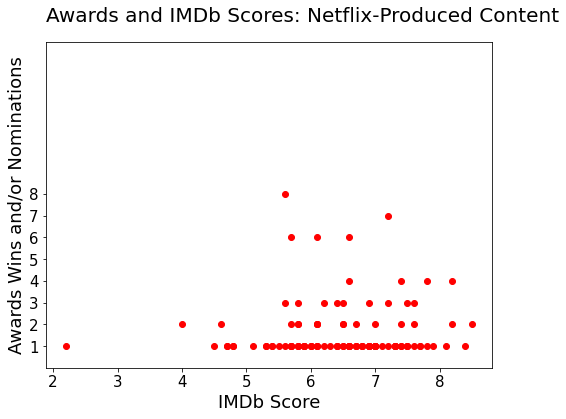

In [84]:
# NETFLIX AWARDS 
awards_scores_netflix = awards_scores_all[(awards_scores_all.NetflixProduced == True)]
netflix_won_movies_y = awards_scores_netflix["TotalAwards"]
netflix_won_imdbscore_x =  awards_scores_netflix["IMDb Score"]

plt.scatter(netflix_won_imdbscore_x, netflix_won_movies_y , color = "red")
plt.yticks(np.arange(1, max(netflix_won_movies_y)+1,1.0))
plt.ylim(0,15)
plt.ylabel("Awards Wins and/or Nominations", size = 18)
plt.xlabel("IMDb Score", size = 18)
plt.title("Awards and IMDb Scores: Netflix-Produced Content", loc="left", pad = 20, size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()


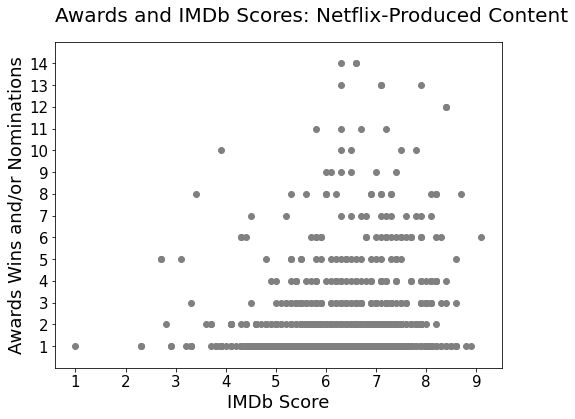

In [85]:
# NON-NETFLIX AWARDS 
awards_scores_nonnetflix = awards_scores_all[(awards_scores_all.NetflixProduced == False)]
nonnetflix_won_movies_y = awards_scores_nonnetflix["TotalAwards"]
nonnetflix_won_imdbscore_x =  awards_scores_nonnetflix["IMDb Score"]

plt.scatter(nonnetflix_won_imdbscore_x,nonnetflix_won_movies_y , color = "grey")
plt.yticks(np.arange(1, max(nonnetflix_won_movies_y)+1,1.0))
plt.ylim(0,15)
plt.ylabel("Awards Wins and/or Nominations", size = 18)
plt.xlabel("IMDb Score", size = 18)
plt.title("Awards and IMDb Scores: Netflix-Produced Content", loc="left", pad = 20, size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()


In [86]:
# CORRELATION OF TOTAL AWARDS / WINS / NOMINATIONS AND IMDB SCORE

all_awards_score_corr = awards_scores_all["TotalAwards"].corr(awards_scores_all["IMDb Score"])
wins_score_corr = awards_scores_all["Winner"].corr(awards_scores_all["IMDb Score"])
noms_score_corr = awards_scores_all["Nominee"].corr(awards_scores_all["IMDb Score"])

print("Correlation between the total number of awards and IMBd Score: " + f"{all_awards_score_corr:.2}")
print("Correlation between the total number of wins and IMBd Score: " + f"{wins_score_corr:.2}")
print("Correlation between the total number of nominations and IMBd Score: " + f"{noms_score_corr:.2}")      
      
# CORRELATION OF TOTAL AWARDS / WINS / NOMINATIONS AND IMDB SCORE AMONG NETFLIX-PRODUCED MOVIES AND TV SERIES

awards_scores_netflix = awards_scores_all[(awards_scores_all.NetflixProduced == True)]
netflix_awards_score_corr = awards_scores_netflix["TotalAwards"].corr(awards_scores_netflix["IMDb Score"])
netflixwins_score_corr = awards_scores_netflix["Winner"].corr(awards_scores_netflix["IMDb Score"])
netflixnoms_score_corr = awards_scores_netflix["Nominee"].corr(awards_scores_netflix["IMDb Score"])

print("----------------------------------")
print("Correlation between Netflix total number of awards and IMBd Score: " + f"{netflix_awards_score_corr:.2}")
print("Correlation between Netflix total number of wins and IMBd Score: " + f"{netflixwins_score_corr:.2}")
print("Correlation between Netflix total number of nominations and IMBd Score: " + f"{netflixnoms_score_corr:.2}")
print("----------------------------------")

# CORRELATION OF TOTAL AWARDS / WINS / NOMINATIONS AND IMDB SCORE AMONG NON-NETFLIX MOVIES AND TV SERIES

awards_scores_nonnetflix = awards_scores_all[(awards_scores_all.NetflixProduced == False)]
nonnetflix_awards_score_corr = awards_scores_nonnetflix["TotalAwards"].corr(awards_scores_nonnetflix["IMDb Score"])
nonnetflixwins_score_corr = awards_scores_nonnetflix["Winner"].corr(awards_scores_nonnetflix["IMDb Score"])
nonnetflixnoms_score_corr = awards_scores_nonnetflix["Nominee"].corr(awards_scores_nonnetflix["IMDb Score"])

print("Correlation between Non-Netflix total number of awards and IMBd Score: " + f"{nonnetflix_awards_score_corr:.2}")
print("Correlation between Non-Netflixtotal number of wins and IMBd Score: " + f"{nonnetflixwins_score_corr:.2}")
print("Correlation between Non-Netflix total number of nominations and IMBd Score: " + f"{nonnetflixnoms_score_corr:.2}")

Correlation between the total number of awards and IMBd Score: 0.15
Correlation between the total number of wins and IMBd Score: 0.17
Correlation between the total number of nominations and IMBd Score: 0.11
----------------------------------
Correlation between Netflix total number of awards and IMBd Score: 0.051
Correlation between Netflix total number of wins and IMBd Score: 0.16
Correlation between Netflix total number of nominations and IMBd Score: -0.051
----------------------------------
Correlation between Non-Netflix total number of awards and IMBd Score: 0.16
Correlation between Non-Netflixtotal number of wins and IMBd Score: 0.17
Correlation between Non-Netflix total number of nominations and IMBd Score: 0.13


#### Awards vs. Scores
The IMBd Score for a TV Series or Movie is not a strong predictor of the number of awards the content has won. There is a slight, positve relationship between the two variables in all cases except for the correlation between award nominations for Netflix content and the IMDb scores. Overall, IMDb Scores are a slightly better predictor of the number of awards among Non-Netflix produced items. 

In [87]:
# JAIPAL

# IIDENTIFY UNIQUE GENRES IN THE DATASET
netflix_content['Genre'].unique()

netflix_content['genre1'] = netflix_content['Genre'].str.split(',', expand=True).iloc[:,:1]

# FIND COLUMN VALUES
netflix_content.columns.values[()]


# SET GENRE VARIABLES
genre_mean = netflix_content.groupby('genre1')["Rotten Tomatoes Score"].mean()
genre_median = netflix_content.groupby('genre1')["Rotten Tomatoes Score"].median()
genre_std = netflix_content.groupby('genre1')["Rotten Tomatoes Score"].std()
rotten_tomatoes_genre_summary_statistics_df = pd.DataFrame({'Rotten Tomatoes Score Mean':genre_mean,
                                           'Rotten Tomatoes Score Median':genre_median,
                                           'Rotten Tomatoes Score STD':genre_std})
rotten_tomatoes_genre_summary_statistics_df = rotten_tomatoes_genre_summary_statistics_df.dropna()

C:\Users\madis\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


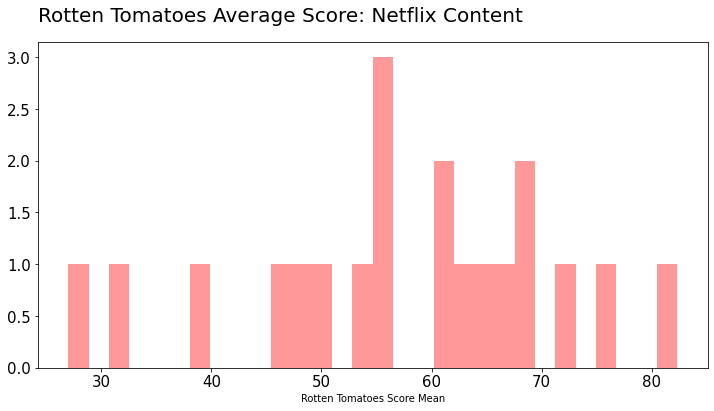

In [88]:
plt.figure(figsize=(12, 6))
sns.distplot(rotten_tomatoes_genre_summary_statistics_df['Rotten Tomatoes Score Mean'], bins=30, kde=False, color = "red")
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.title("Rotten Tomatoes Average Score: Netflix Content", loc="left", pad = 20, size = 20)
plt.show()
sns.set_style('whitegrid')

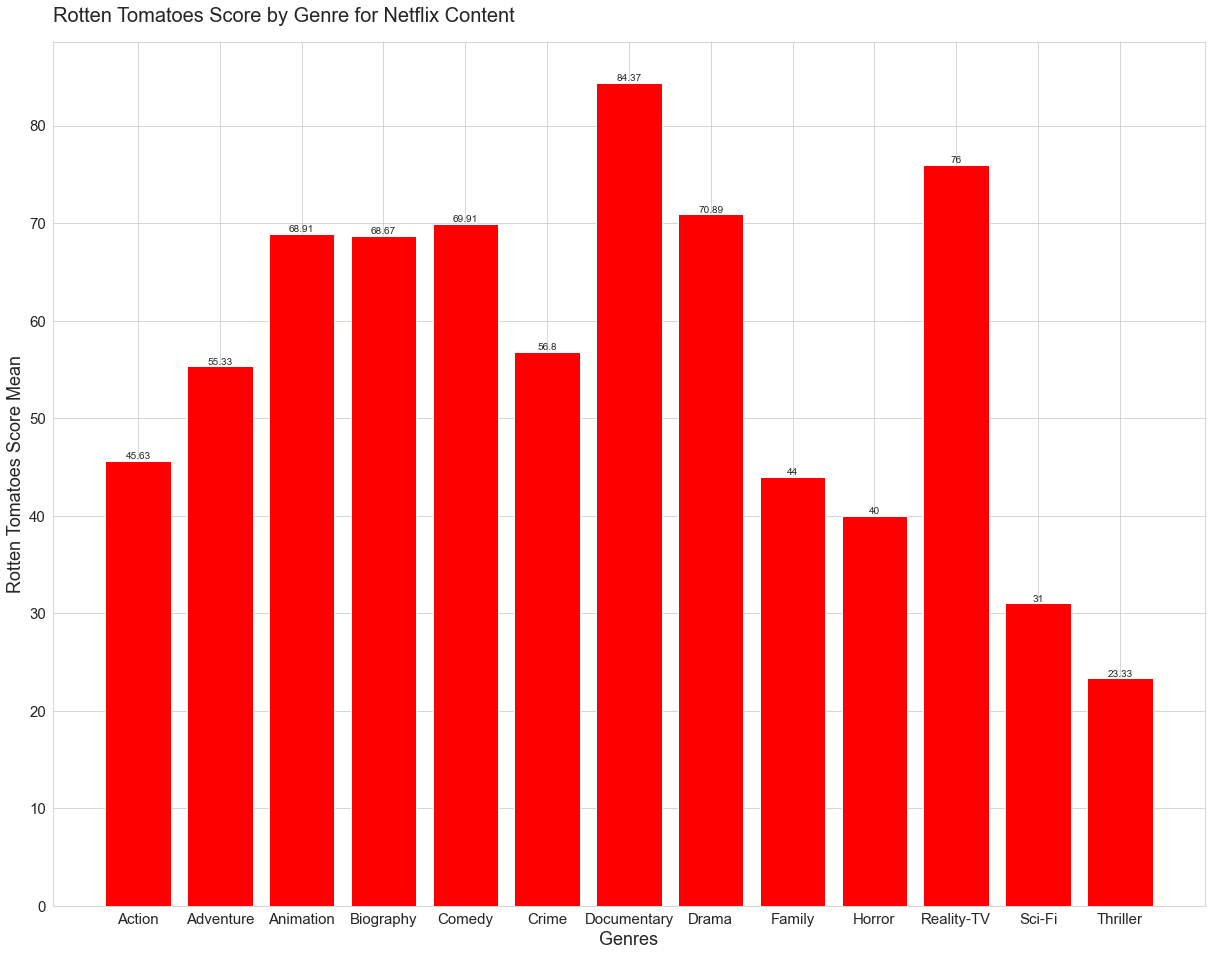

In [89]:
# AVERAGE ROTTEN TOMATO SCORES BY GENRE FOR NETFLIX CONTENT
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Horror', 'Reality-TV', 'Sci-Fi', 'Thriller']
RT = [45.63, 55.33, 68.91, 68.67, 69.91, 56.8, 84.37, 70.89, 44.00, 40.00, 76.00, 31.00, 23.33]
ax.bar(genres, RT, color = "red")
ax.title
ax.set_ylabel('Rotten Tomatoes Score Mean', size = 18)
ax.set_xlabel('Genres', size = 18)
ax.set_title('Rotten Tomatoes Score by Genre for Netflix Content', size = 20, pad = 20, loc = "left")
ax.bar_label(ax.containers[0], label_type='edge')
plt.yticks(size = 15)
plt.xticks(size = 15)

plt.savefig("../NetflixBarplotRottenTomatoes.png")
plt.show()

In [90]:
# METACRITIC DATA - NETFLIX CONTENT

genre_mean = netflix_content.groupby('genre1')["Metacritic Score"].mean()
genre_median = netflix_content.groupby('genre1')["Metacritic Score"].median()
genre_std = netflix_content.groupby('genre1')["Metacritic Score"].std()
metacritic_genre_summary_statistics_df = pd.DataFrame({'Metacritic Score Mean':genre_mean,
                                           'Metacritic Score Median':genre_median,
                                           'Metacritic Score STD':genre_std})
metacritic_genre_summary_statistics_df = metacritic_genre_summary_statistics_df.dropna()
# metacritic_genre_summary_statistics_df

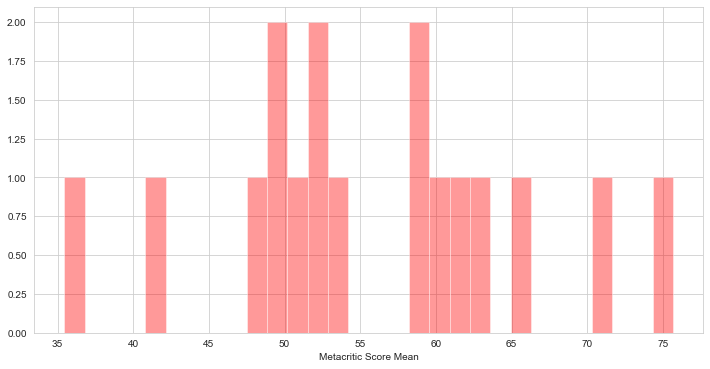

In [91]:
plt.figure(figsize=(12, 6))
sns.distplot(metacritic_genre_summary_statistics_df['Metacritic Score Mean'], bins=30, kde=False, color = "red")
sns.set_style('whitegrid')

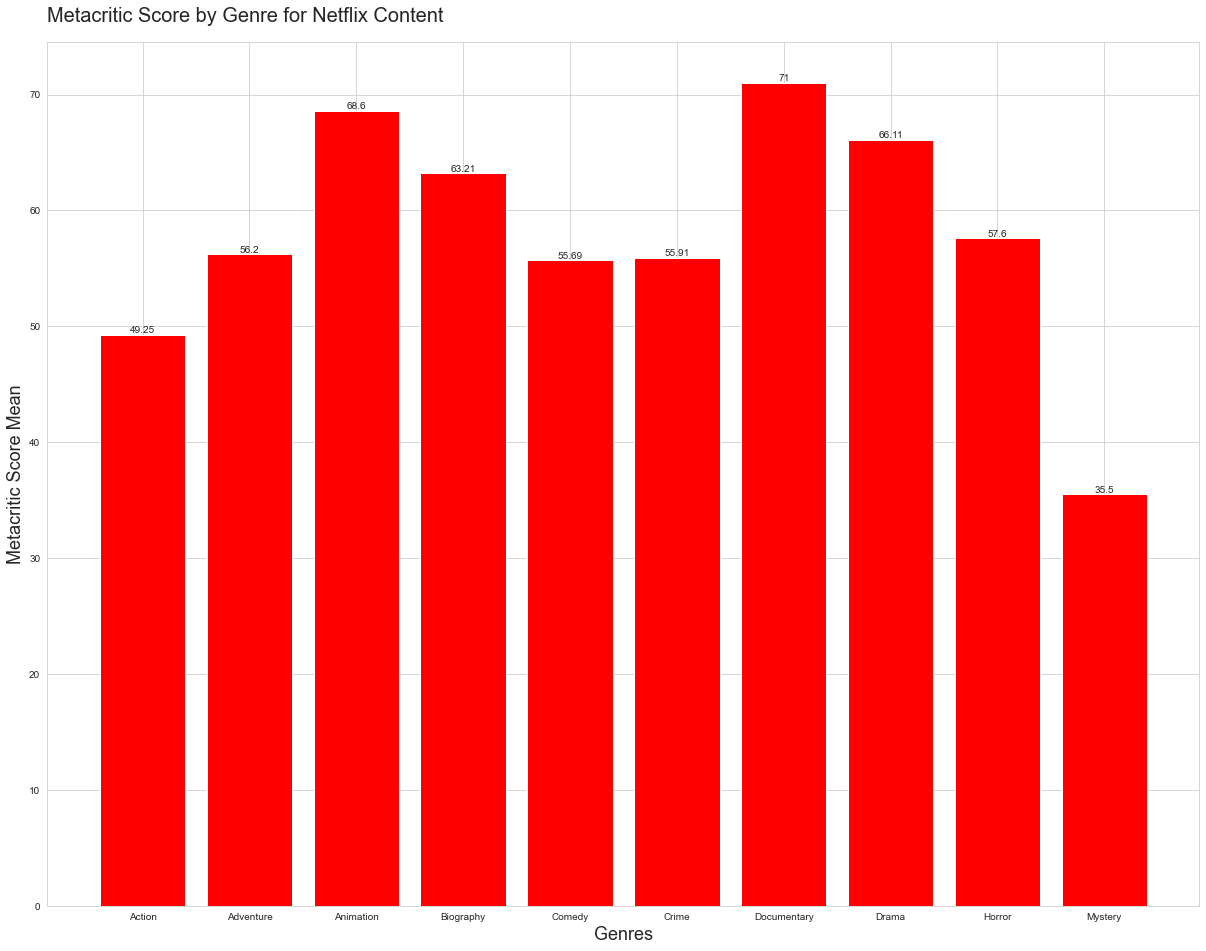

In [92]:
# METACRITIC SCORE BY GENRE FOR NETFLIC CONTENT
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Mystery']
Metacritic = [49.25, 56.20, 68.60, 63.21, 55.69, 55.91, 71.00, 66.11, 57.60, 35.50]
ax.bar(genres, Metacritic, color = "red")
ax.title
ax.set_ylabel('Metacritic Score Mean', size = 18)
ax.set_xlabel('Genres', size = 18)
ax.set_title('Metacritic Score by Genre for Netflix Content', size = 20, pad = 20, loc = "left")
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig("../NetflixBarplotMetacritic.png")
plt.show()

In [93]:
# HIDDEN GEM SCORE - NETFLIX CONTENT

genre_mean = netflix_content.groupby('genre1')["Hidden Gem Score"].mean()
genre_median = netflix_content.groupby('genre1')["Hidden Gem Score"].median()
genre_std = netflix_content.groupby('genre1')["Hidden Gem Score"].std()
hidden_gem_genre_summary_statistics_df = pd.DataFrame({'Hidden Gem Score Mean':genre_mean,
                                           'Hidden Gem Score Median':genre_median,
                                           'Hidden Gem Score STD':genre_std})
hidden_gem_genre_summary_statistics_df = hidden_gem_genre_summary_statistics_df.dropna()
# hidden_gem_genre_summary_statistics_df

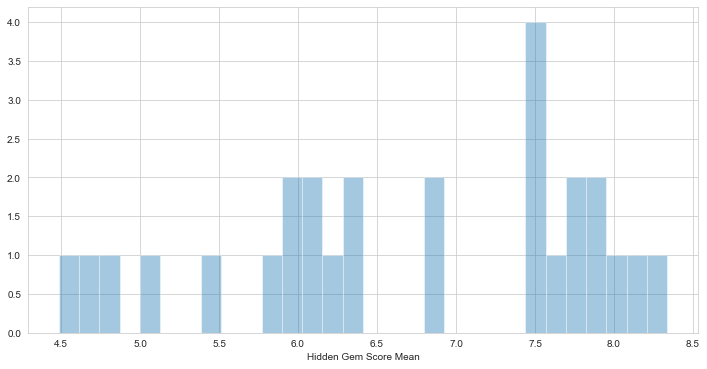

In [94]:
plt.figure(figsize=(12, 6))
sns.distplot(hidden_gem_genre_summary_statistics_df['Hidden Gem Score Mean'], bins=30, kde=False)
sns.set_style('whitegrid')

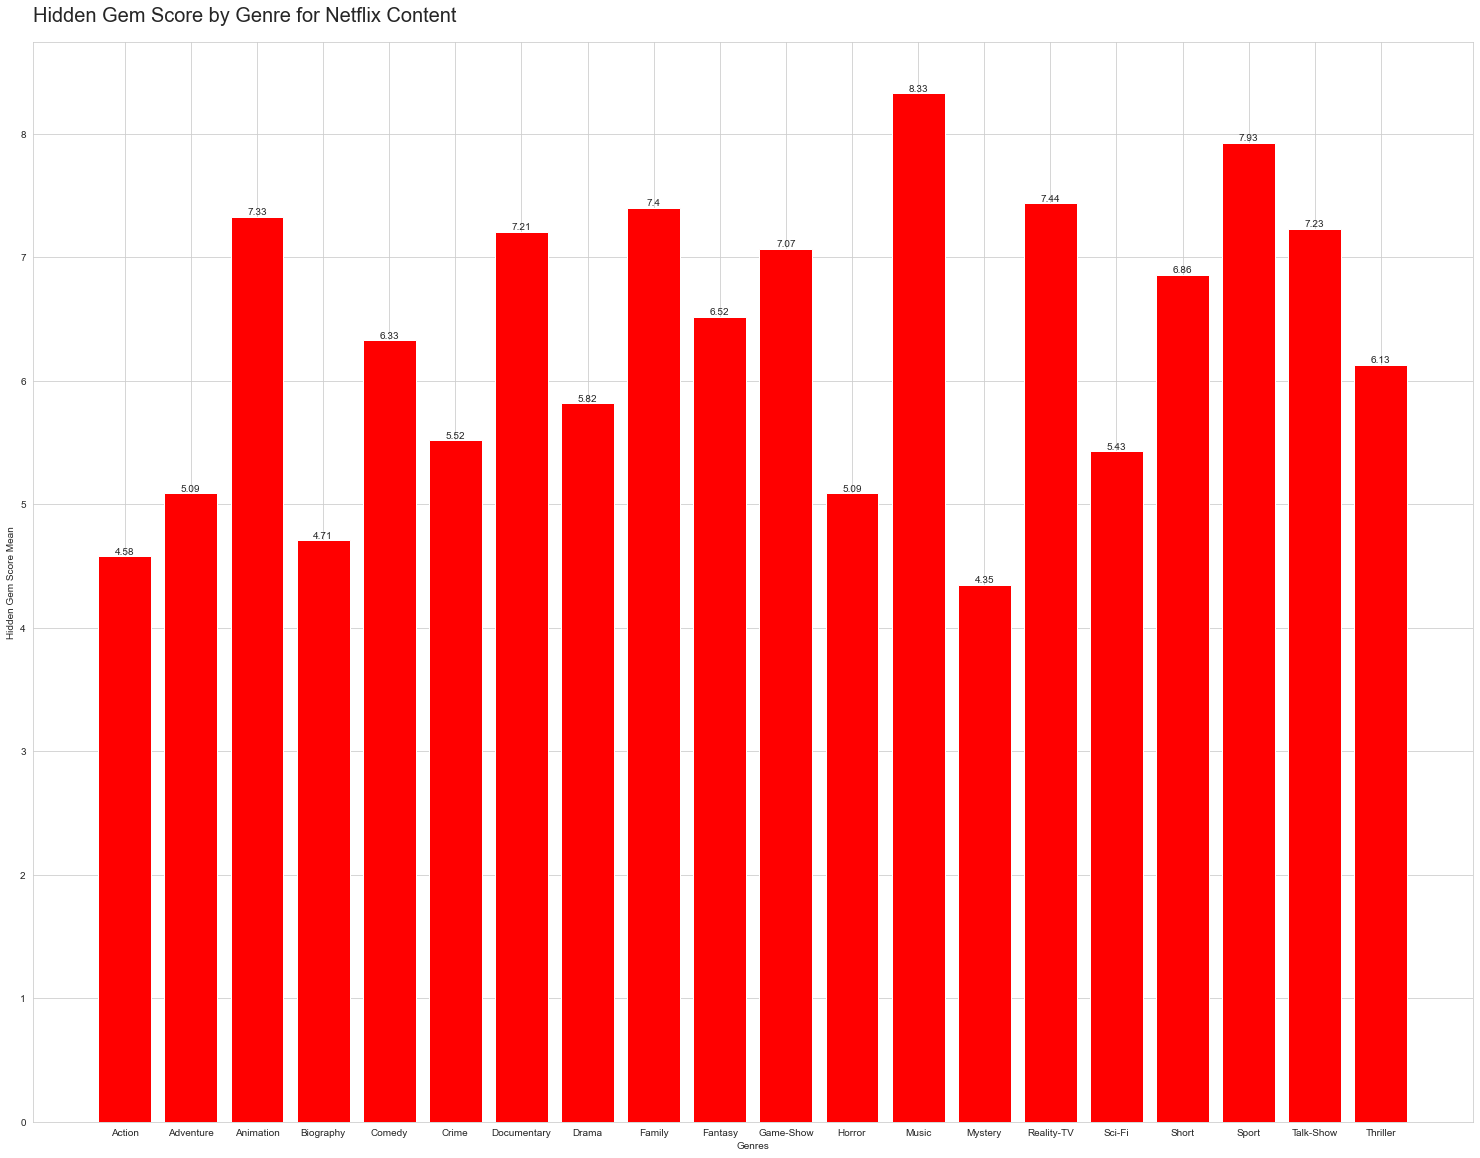

In [95]:
# HIDDEN GEM SCORE BY GENRE - NETFLIX CONTENT
fig = plt.figure()
ax = fig.add_axes([0,0,2.5,2.5])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'Horror', 'Music', 'Mystery', 'Reality-TV', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller']
HiddenGem = [4.58, 5.09, 7.33, 4.71, 6.33, 5.52, 7.21, 5.82, 7.40, 6.52, 7.07, 5.09, 8.33, 4.35, 7.44, 5.43, 6.86, 7.93, 7.23, 6.13]
ax.bar(genres, HiddenGem, color = "red")
ax.title
ax.set_ylabel('Hidden Gem Score Mean')
ax.set_xlabel('Genres')
ax.set_title('Hidden Gem Score by Genre for Netflix Content', size = 20, pad = 20, loc = "left")
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig("../NetflixBarplotHiddenGem.png")
plt.show()

In [96]:
# IMDB SCORE - NETFLIX CONTENT
genre_mean = netflix_content.groupby('genre1')["IMDb Score"].mean()
genre_median = netflix_content.groupby('genre1')["IMDb Score"].median()
genre_std = netflix_content.groupby('genre1')["IMDb Score"].std()
imdb_genre_summary_statistics_df = pd.DataFrame({'IMDb Score Mean':genre_mean,
                                           'IMDb Score Median':genre_median,
                                           'IMDb Score STD':genre_std})
imdb_genre_summary_statistics_df = imdb_genre_summary_statistics_df.dropna()
# imdb_genre_summary_statistics_df

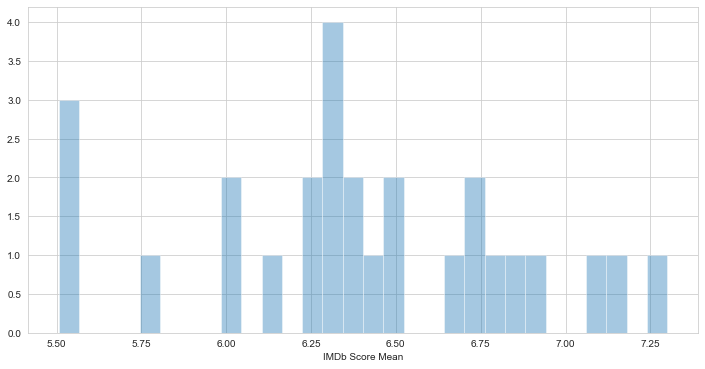

In [97]:
plt.figure(figsize=(12, 6))
sns.distplot(imdb_genre_summary_statistics_df['IMDb Score Mean'], bins=30, kde=False)
sns.set_style('whitegrid')

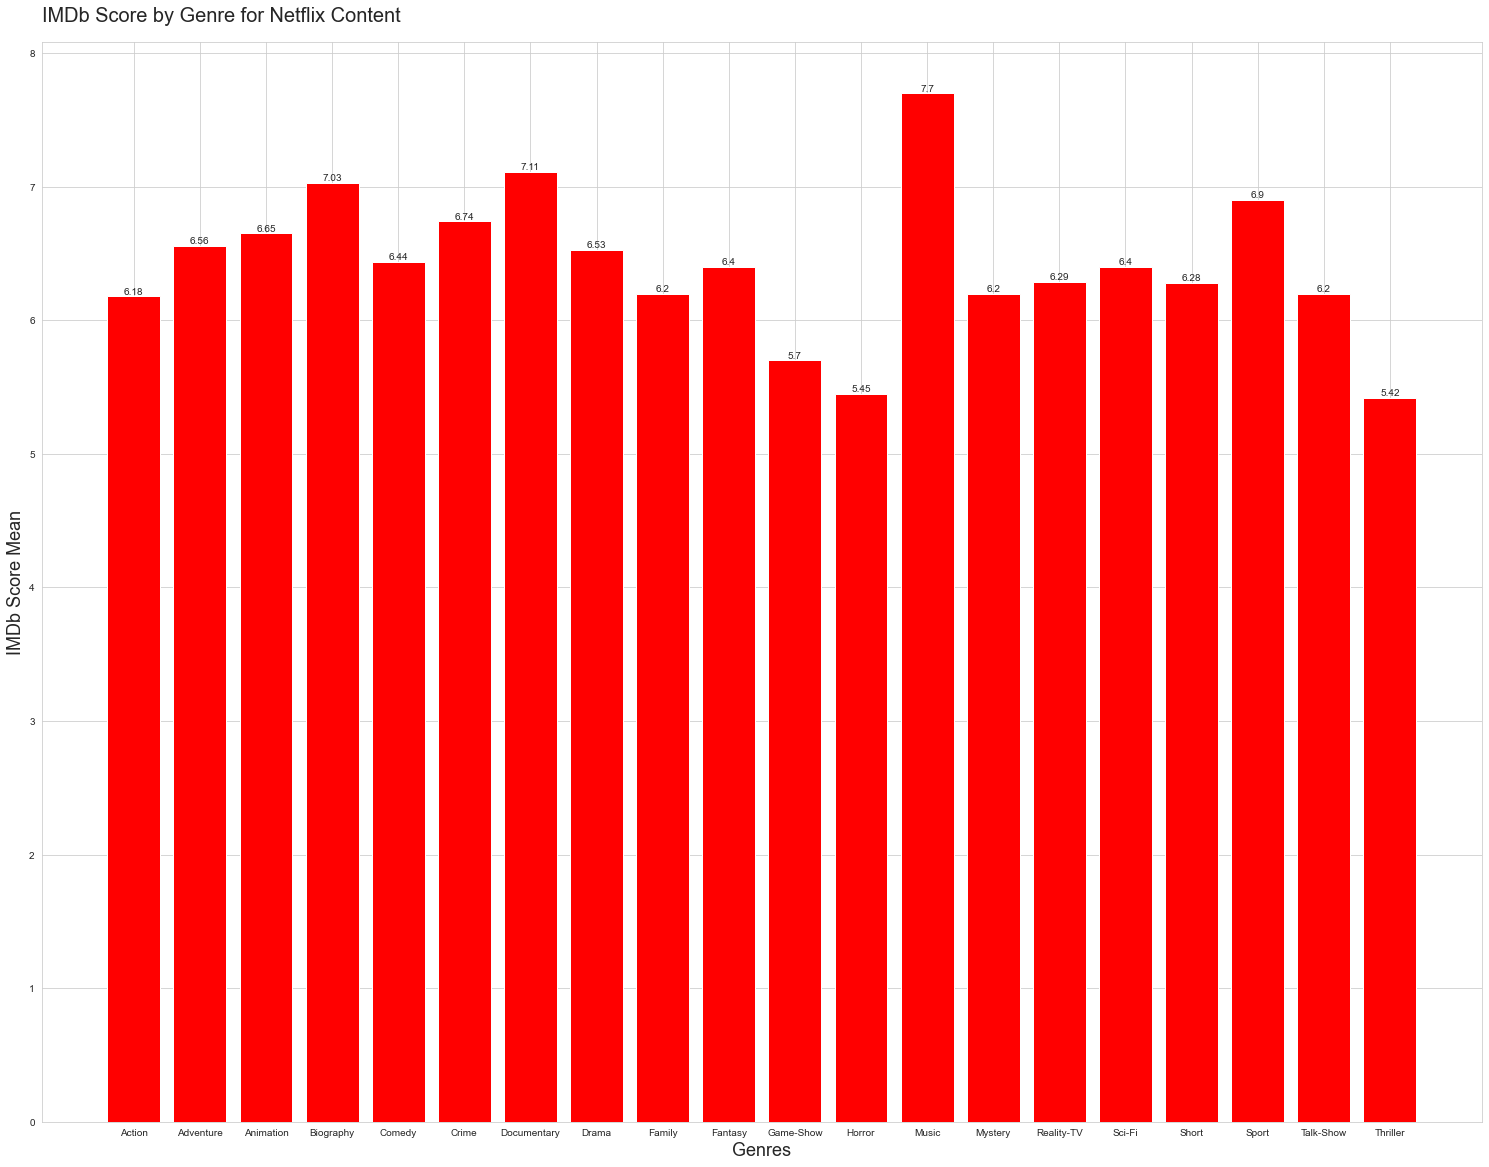

In [98]:
# IMBD SCORE BY GENRE - NETFLIX CONTENT

fig = plt.figure()
ax = fig.add_axes([0,0,2.5,2.5])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'Horror', 'Music', 'Mystery', 'Reality-TV', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller']
IMDb= [6.18, 6.56, 6.65, 7.03, 6.44, 6.74, 7.11, 6.53, 6.20, 6.40, 5.70, 5.45, 7.70, 6.20, 6.29, 6.40, 6.28, 6.90, 6.20, 5.42]
ax.bar(genres, IMDb, color = "red")
# ax.title
ax.set_ylabel('IMDb Score Mean', size = 18)
ax.set_xlabel('Genres', size = 18)
ax.set_title('IMDb Score by Genre for Netflix Content', size = 20, pad = 20, loc = "left")
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig("../NetflixBarplotIMDbScores.png")
plt.show()

In [99]:
# NON-NETFLIX DATA

# df_nonnetflix.head(10)
df_nonnetflix.info()
df_nonnetflix.nunique()

df_nonnetflix['Genre'].unique()

df_nonnetflix['genre1'] = df_nonnetflix['Genre'].str.split(',', expand=True).iloc[:,:1]
# df_nonnetflix

df_nonnetflix.columns.values[()]
df_nonnetflix.genre1.nunique()
df_nonnetflix.genre1.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15480 entries, 0 to 15479
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  15480 non-null  object 
 1   Genre                  13770 non-null  object 
 2   Tags                   15413 non-null  object 
 3   Languages              13545 non-null  object 
 4   Series or Movie        15480 non-null  object 
 5   Hidden Gem Score       13379 non-null  float64
 6   Country Availability   15461 non-null  object 
 7   Runtime                15479 non-null  object 
 8   Director               10772 non-null  object 
 9   Writer                 11150 non-null  object 
 10  Actors                 13555 non-null  object 
 11  View Rating            8456 non-null   object 
 12  IMDb Score             13381 non-null  float64
 13  Rotten Tomatoes Score  6382 non-null   float64
 14  Metacritic Score       4336 non-null   float64
 15  Aw

Comedy         3407
Drama          2567
Action         2182
Animation      1649
Documentary    1028
Crime           716
Biography       433
Adventure       429
Horror          374
Short           234
Reality-TV      119
Family          117
Romance         107
Thriller        105
Mystery          68
Fantasy          65
Game-Show        40
Music            28
Sci-Fi           21
Musical          20
Adult            15
History          12
Talk-Show        10
Sport            10
Western           9
News              2
War               2
Film-Noir         1
Name: genre1, dtype: int64

In [100]:
genre_mean = df_nonnetflix.groupby('genre1')["Rotten Tomatoes Score"].mean()
genre_median = df_nonnetflix.groupby('genre1')["Rotten Tomatoes Score"].median()
genre_std = df_nonnetflix.groupby('genre1')["Rotten Tomatoes Score"].std()
rotten_tomatoes_genre_summary_statistics_df = pd.DataFrame({'Rotten Tomatoes Score Mean':genre_mean,
                                           'Rotten Tomatoes Score Median':genre_median,
                                           'Rotten Tomatoes Score STD':genre_std})
rotten_tomatoes_genre_summary_statistics_df = rotten_tomatoes_genre_summary_statistics_df.dropna()
rotten_tomatoes_genre_summary_statistics_df

,Rotten Tomatoes Score Mean,Rotten Tomatoes Score Median,Rotten Tomatoes Score STD
genre1,,,
Action,52.908975,53.0,26.475995
Adventure,61.041045,66.0,25.829936
Animation,65.734015,73.0,24.549810
Biography,68.336420,73.5,22.251610
Comedy,56.328155,58.0,26.811598
Crime,62.290960,69.0,27.487573
Documentary,82.318033,89.0,19.326501
Drama,65.247347,71.0,25.297641
Family,55.857143,50.0,23.009315


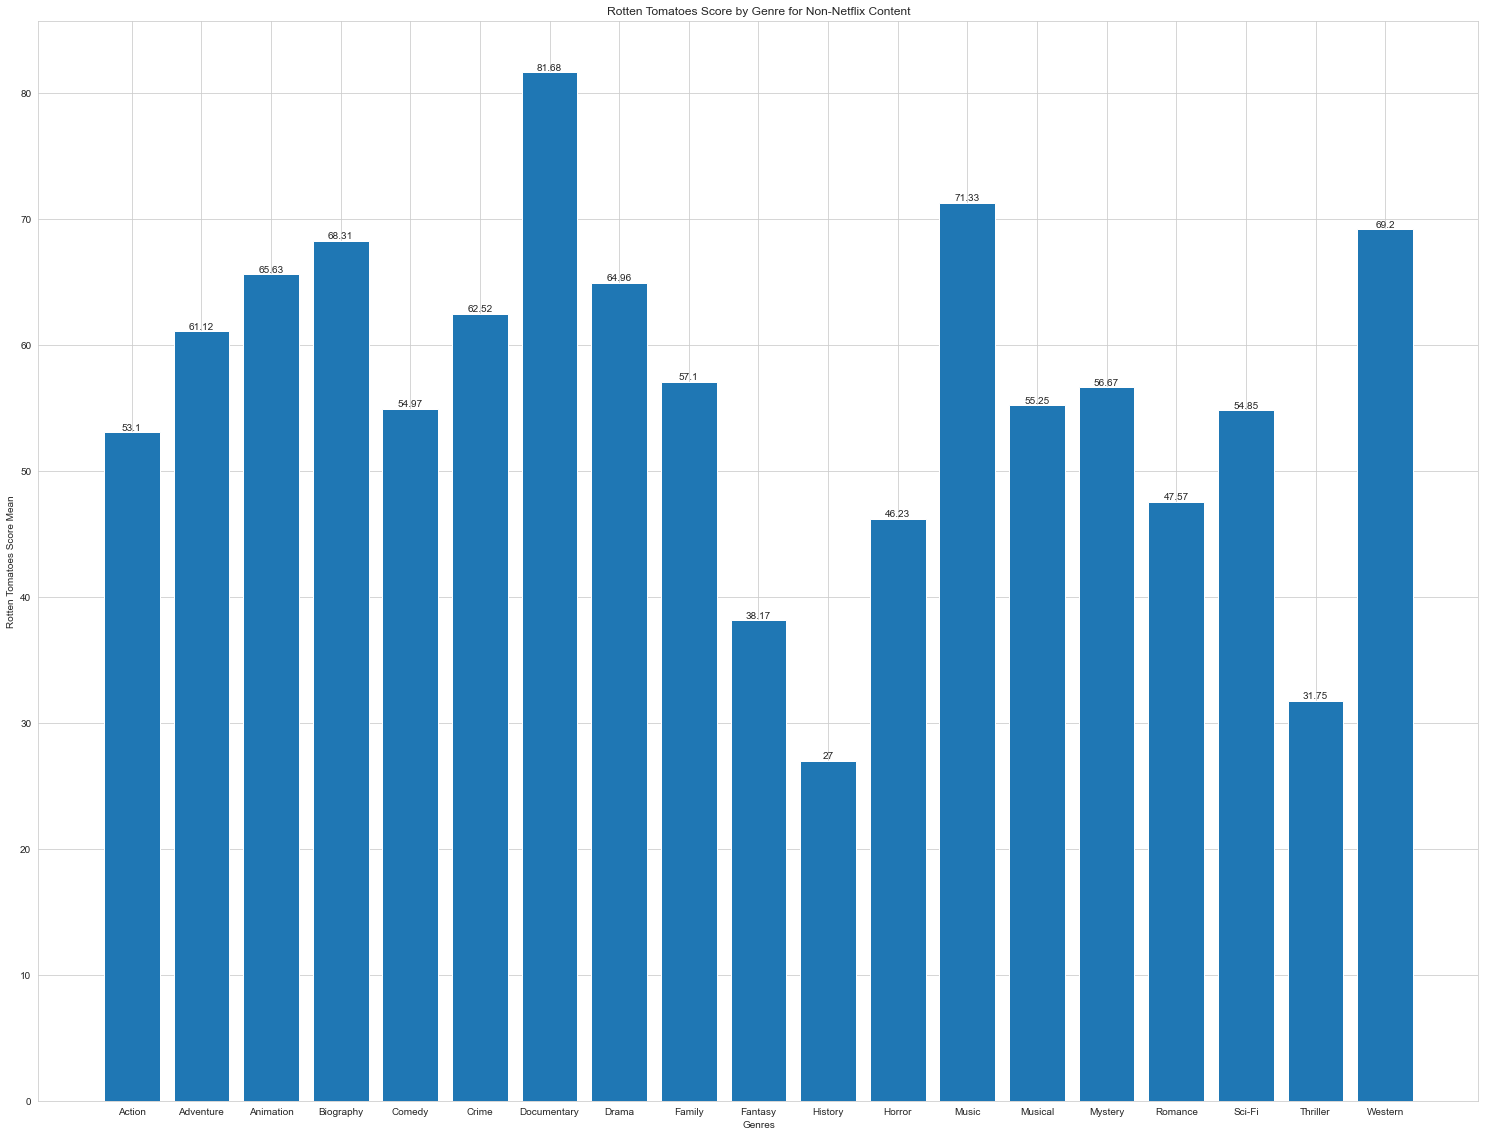

In [101]:
fig = plt.figure()
ax = fig.add_axes([0,0,2.5,2.5])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Western']
RT = [53.10, 61.12, 65.63, 68.31, 54.97, 62.52, 81.68, 64.96, 57.10, 38.17, 27.00, 46.23, 71.33, 55.25, 56.67, 47.57, 54.85, 31.75, 69.20]
ax.bar(genres, RT)
ax.title
ax.set_ylabel('Rotten Tomatoes Score Mean')
ax.set_xlabel('Genres')
ax.set_title('Rotten Tomatoes Score by Genre for Non-Netflix Content')
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig("../NonNetflixBarplotRottenTomatoes.png")
plt.show()

In [102]:
genre_mean = df_nonnetflix.groupby('genre1')["Metacritic Score"].mean()
genre_median = df_nonnetflix.groupby('genre1')["Metacritic Score"].median()
genre_std = df_nonnetflix.groupby('genre1')["Metacritic Score"].std()
metacritic_genre_summary_statistics_df = pd.DataFrame({'Metacritic Score Mean':genre_mean,
                                           'Metacritic Score Median':genre_median,
                                           'Metacritic Score STD':genre_std})
metacritic_genre_summary_statistics_df = metacritic_genre_summary_statistics_df.dropna()
metacritic_genre_summary_statistics_df

,Metacritic Score Mean,Metacritic Score Median,Metacritic Score STD
genre1,,,
Action,51.518810,51.0,16.423450
Adventure,58.954774,58.0,17.604033
Animation,60.772321,61.5,16.226451
Biography,62.837209,64.0,14.071132
Comedy,53.528962,54.0,17.047045
Crime,59.541667,60.0,17.963159
Documentary,71.451163,72.0,10.896119
Drama,61.780193,63.0,17.674677
Family,75.666667,69.0,13.316656


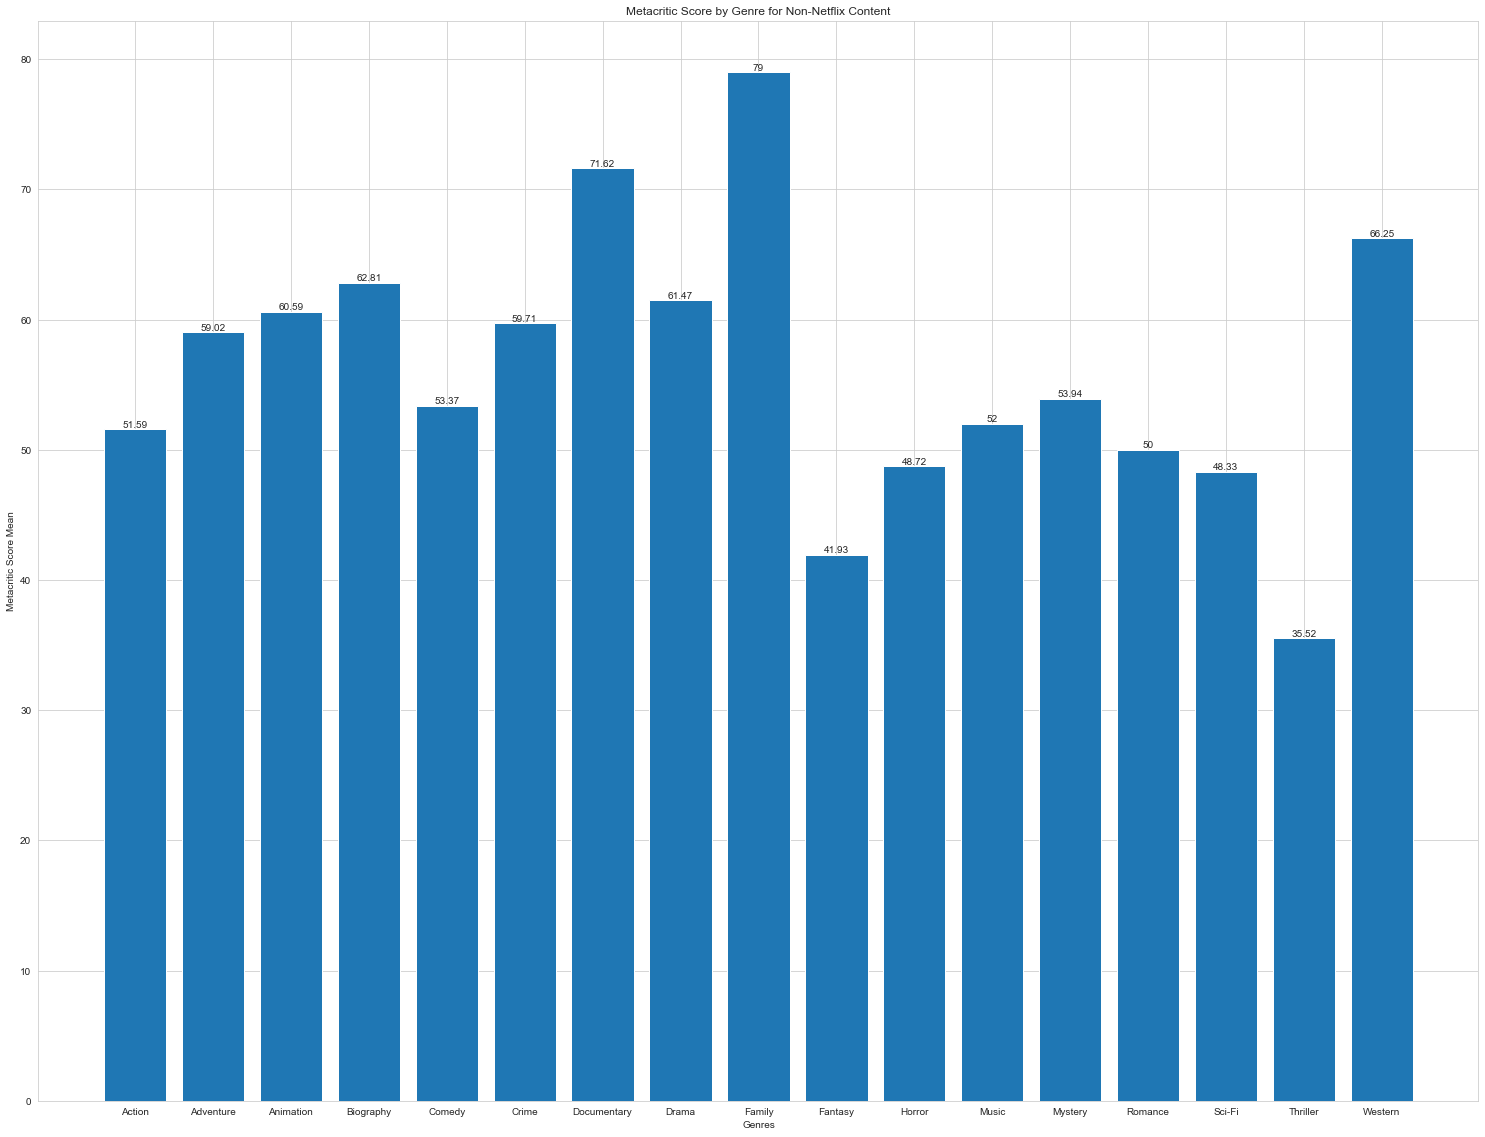

In [103]:
fig = plt.figure()
ax = fig.add_axes([0,0,2.5,2.5])
genres =  ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'Western']
Metacritic = [51.59, 59.02, 60.59, 62.81, 53.37, 59.71, 71.62, 61.47, 79.00, 41.93, 48.72, 52.00, 53.94, 50.00, 48.33, 35.52, 66.25]
ax.bar(genres, Metacritic)
ax.title
ax.set_ylabel('Metacritic Score Mean')
ax.set_xlabel('Genres')
ax.set_title('Metacritic Score by Genre for Non-Netflix Content')
ax.bar_label(ax.containers[0], label_type='edge')
plt.savefig("../NonNetflixBarplotMetacritic.png")
plt.show()

In [104]:
genre_mean = df_nonnetflix.groupby('genre1')["Hidden Gem Score"].mean()
genre_median = df_nonnetflix.groupby('genre1')["Hidden Gem Score"].median()
genre_std = df_nonnetflix.groupby('genre1')["Hidden Gem Score"].std()
hidden_gem_genre_summary_statistics_df = pd.DataFrame({'Hidden Gem Score Mean':genre_mean,
                                           'Hidden Gem Score Median':genre_median,
                                           'Hidden Gem Score STD':genre_std})
hidden_gem_genre_summary_statistics_df = hidden_gem_genre_summary_statistics_df.dropna()
hidden_gem_genre_summary_statistics_df

,Hidden Gem Score Mean,Hidden Gem Score Median,Hidden Gem Score STD
genre1,,,
Action,4.484018,3.90,2.147341
Adult,8.337500,8.35,0.450198
Adventure,5.004717,4.20,2.092467
Animation,6.844866,7.70,1.884676
Biography,4.717783,4.00,1.900434
Comedy,5.964082,6.80,2.168005
Crime,5.425598,4.80,2.134701
Documentary,7.562474,8.10,1.443380
Drama,6.217320,7.20,2.161451


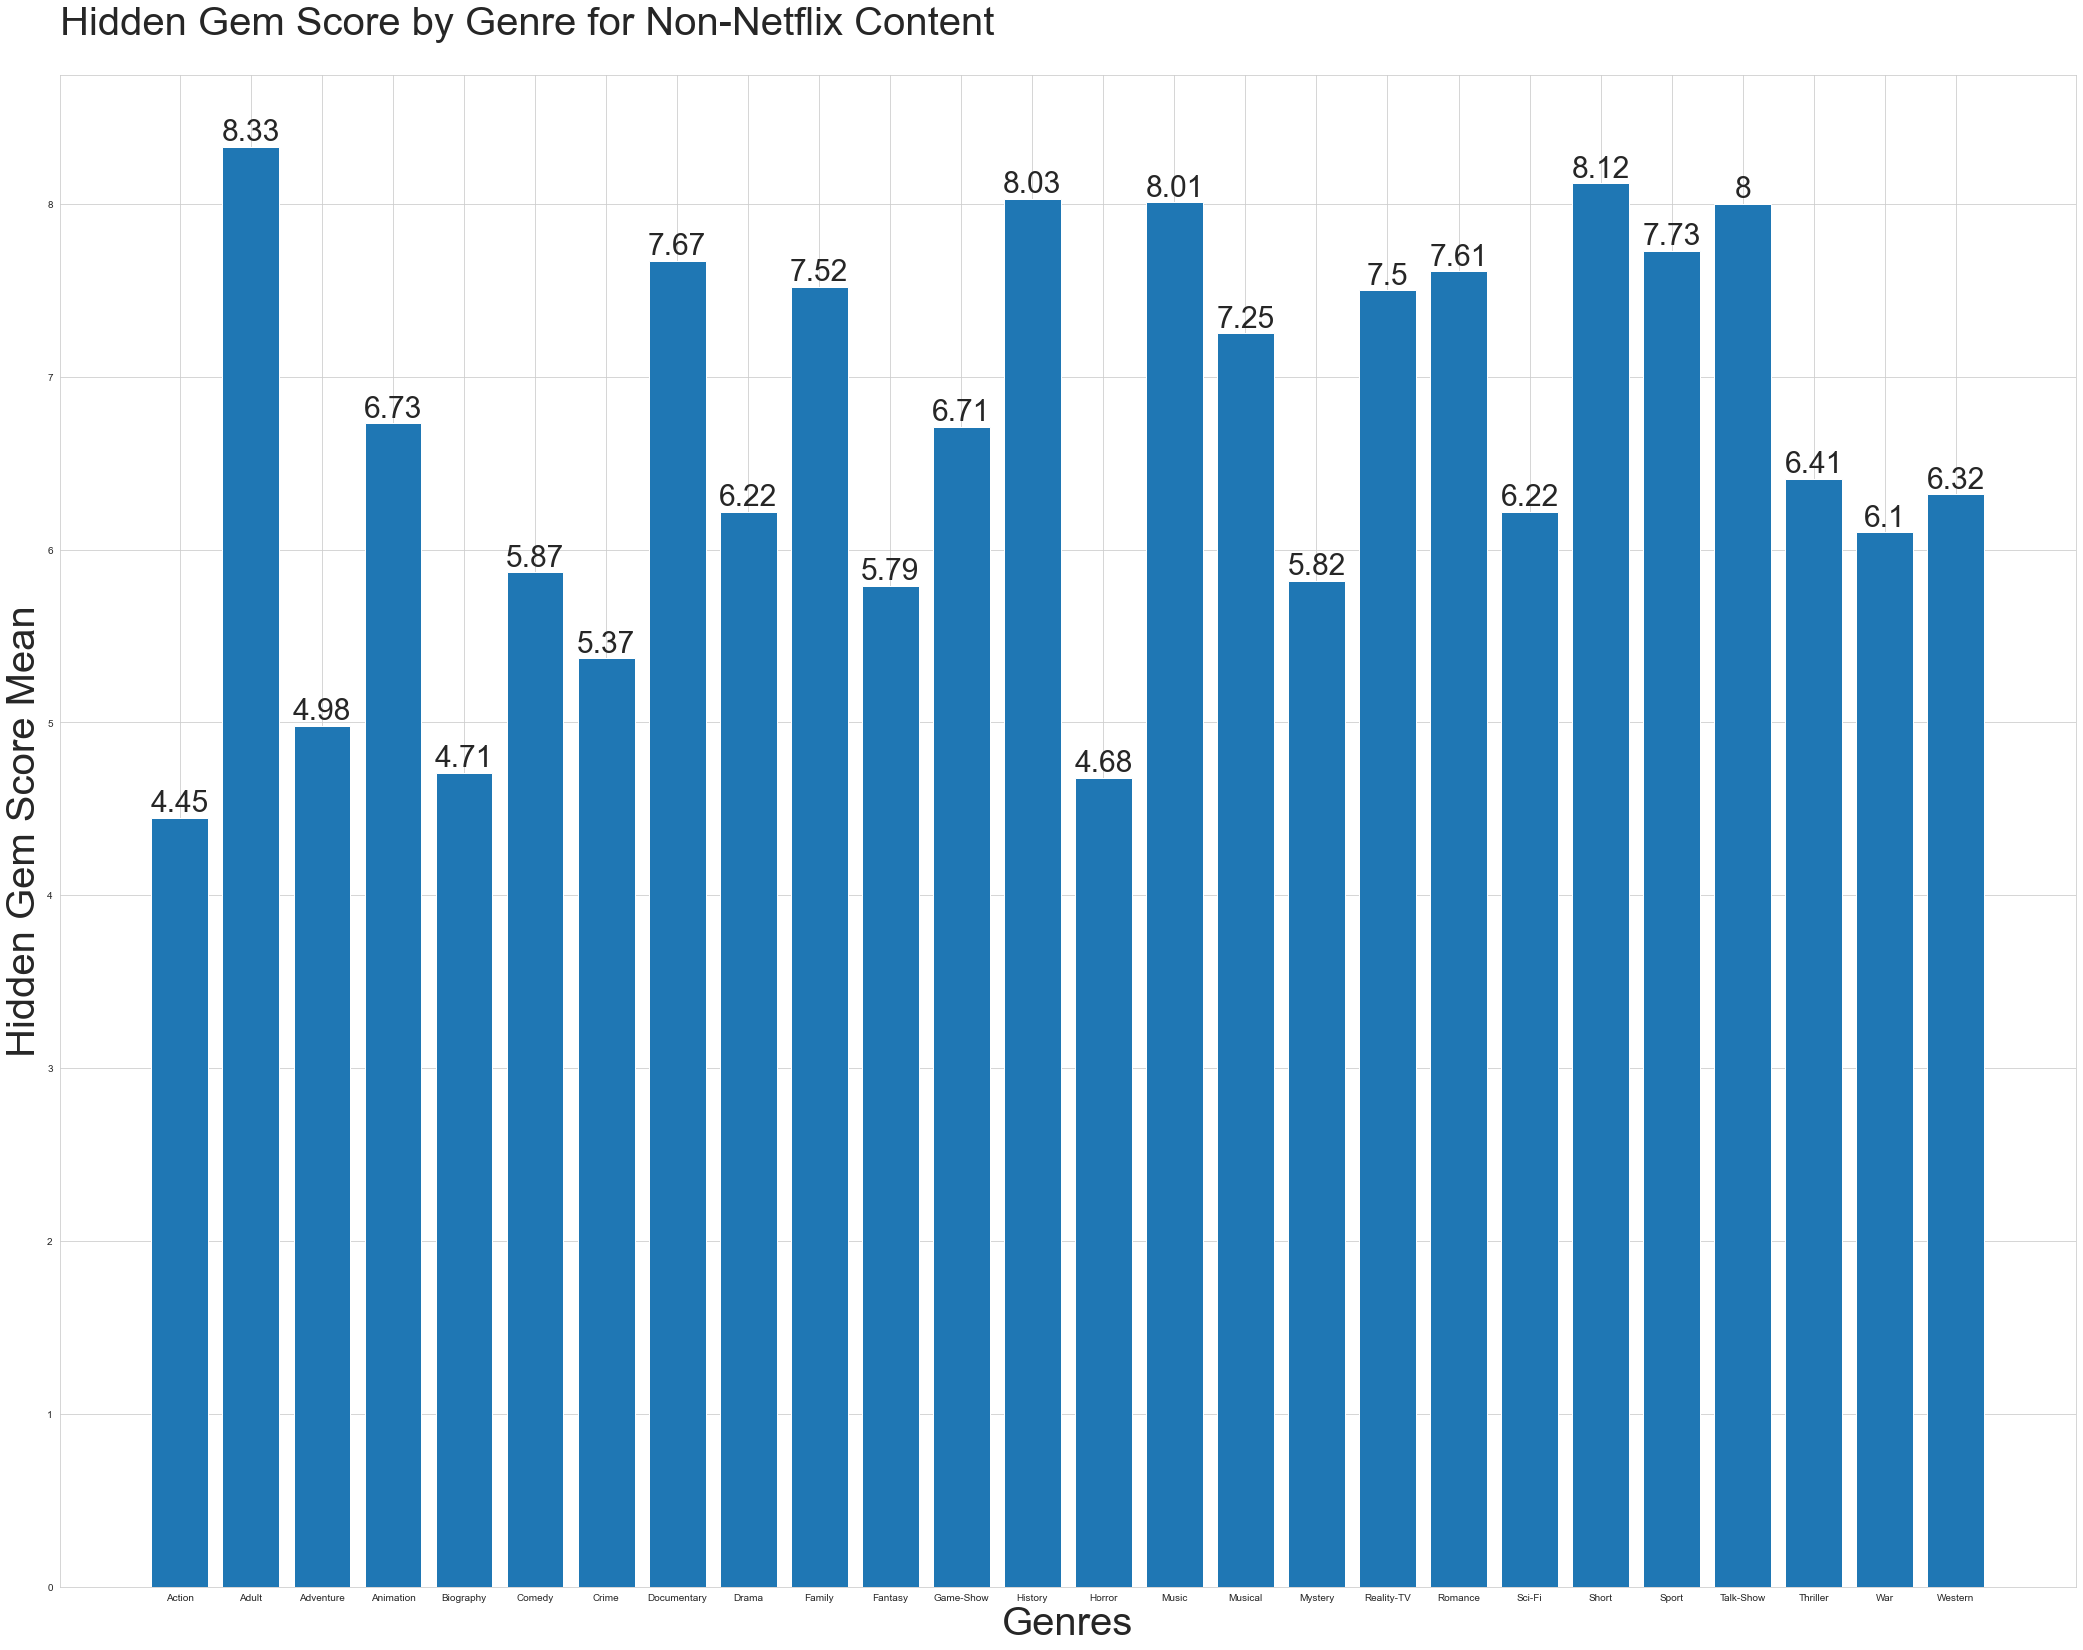

In [111]:
fig = plt.figure()
ax = fig.add_axes([0,0,3.5,3.5])
genres =  ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
HiddenGem = [4.45, 8.33, 4.98, 6.73, 4.71, 5.87, 5.37, 7.67, 6.22, 7.52, 5.79, 6.71, 8.03, 4.68, 8.01, 7.25, 5.82, 7.50, 7.61, 6.22, 8.12, 7.73, 8.00, 6.41, 6.10, 6.32]
ax.bar(genres, HiddenGem)
ax.title
ax.set_ylabel('Hidden Gem Score Mean', size = 40)
ax.set_xlabel('Genres', size = 40)
ax.set_title('Hidden Gem Score by Genre for Non-Netflix Content', size = 40, pad = 40, loc = "left")
ax.bar_label(ax.containers[0], label_type='edge', size = 30)
plt.savefig("../NonNetflixBarplotHiddenGem.png")
plt.show()

In [106]:
genre_mean = df_nonnetflix.groupby('genre1')["IMDb Score"].mean()
genre_median = df_nonnetflix.groupby('genre1')["IMDb Score"].median()
genre_std = df_nonnetflix.groupby('genre1')["IMDb Score"].std()
imdb_genre_summary_statistics_df = pd.DataFrame({'IMDb Score Mean':genre_mean,
                                           'IMDb Score Median':genre_median,
                                           'IMDb Score STD':genre_std})
imdb_genre_summary_statistics_df = imdb_genre_summary_statistics_df.dropna()
imdb_genre_summary_statistics_df

,IMDb Score Mean,IMDb Score Median,IMDb Score STD
genre1,,,
Action,6.255520,6.40,1.099144
Adult,6.725000,6.75,0.897218
Adventure,6.336321,6.40,1.189653
Animation,6.836901,7.00,1.072038
Biography,6.919400,7.00,0.818701
Comedy,6.259893,6.30,1.178193
Crime,6.796343,6.80,1.091588
Documentary,7.135618,7.20,0.929550
Drama,6.645280,6.70,1.028687


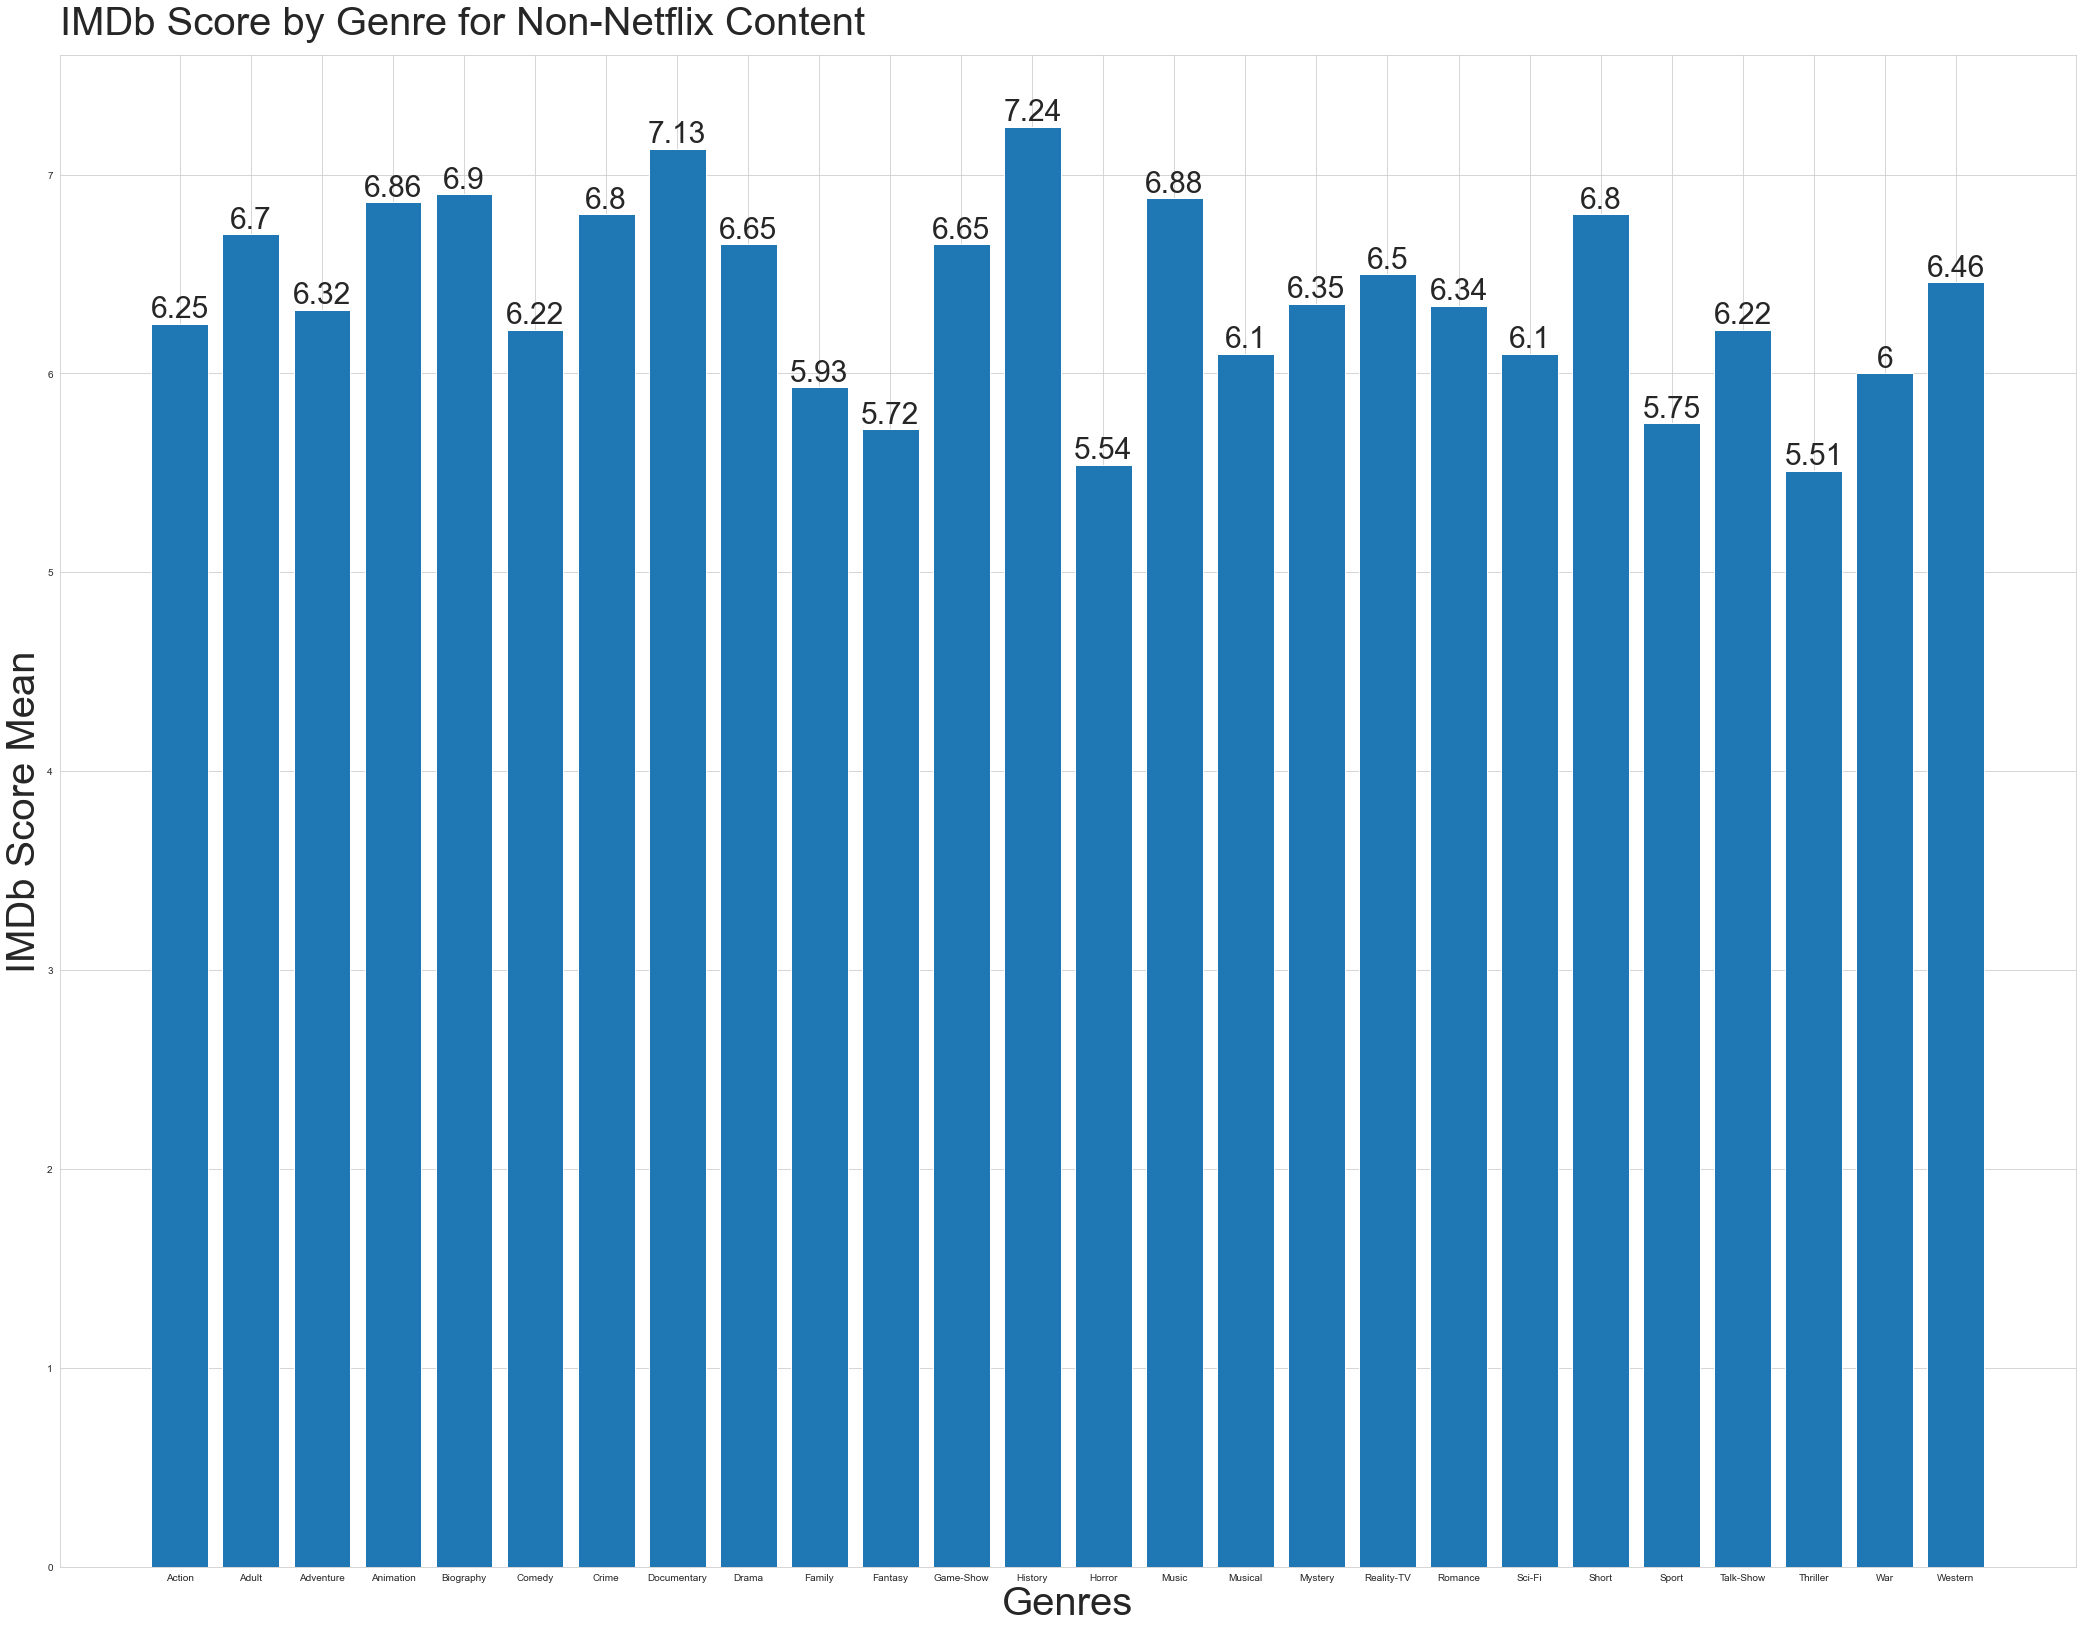

In [114]:
fig = plt.figure()
ax = fig.add_axes([0,0,3.5,3.5])
genres =  ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
IMDb= [6.25, 6.70, 6.32, 6.86, 6.90, 6.22, 6.80, 7.13, 6.65, 5.93, 5.72, 6.65, 7.24, 5.54, 6.88, 6.10, 6.35, 6.50, 6.34, 6.10, 6.80, 5.75, 6.22, 5.51, 6.00, 6.46]
ax.bar(genres, IMDb)
ax.title
ax.set_ylabel('IMDb Score Mean', size = 40)
ax.set_xlabel('Genres', size = 40)
ax.set_title('IMDb Score by Genre for Non-Netflix Content', size = 40, loc = "left", pad = "20")
ax.bar_label(ax.containers[0], label_type='edge', size = 30)
plt.savefig("../NonNetflixBarplotIMDbScores.png")
plt.show()